In [129]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
import os
import numpy as np
from Classification.cnn1D_model import VibrationDataset, CNN1D_Wide
from Classification.cnn1D_model import train_and_evaluate, train_and_evaluate_with_kfold
import torch
from torch.utils.data import Dataset, DataLoader, random_split,Subset
from sklearn.model_selection import train_test_split
import random
import pandas as pd
from utils.baseline_xai import predict_single, summarize_attributions
from utils.baseline_xai import grad_times_input_relevance, smoothgrad_relevance, occlusion_signal_relevance, occlusion_simpler_relevance
from  visualization.relevance_visualization import visualize_with_label_attribution, visualize_lrp_single_sample, visualize_lrp_dft, visualize_lrp_fft, visualize_crp_heatmap, visualize_crp_timefreq, visualize_lrp_dft_extended
from utils.xai_implementation import compute_lrp_relevance, compute_dft_lrp_relevance, compute_fft_lrp_relevance, compute_dft_lrp_relevance_2, compute_dft_lrp_relevance_with_timefreq
from sklearn.model_selection import GroupKFold
from collections import Counter
from utils.crp_utils import *

In [131]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [132]:
device

device(type='cuda')

In [133]:
# Load dataset, Stratify based on Lable and Operation, so that the train, test, val sets have appropriate amount of each group

data_directory = "../data/final/new_selection/normalized_windowed_downsampled_data"
dataset = VibrationDataset(data_directory, augment_bad=False)

# Create a combined stratification key (label_operation)
stratify_key = [f"{lbl}_{op}" for lbl, op in zip(dataset.labels, dataset.operations)]

# Stratified split by both label and operation
train_idx, temp_idx = train_test_split(
    range(len(dataset)), test_size=0.3, stratify=stratify_key
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=[stratify_key[i] for i in temp_idx]
)

# Create Subset datasets
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Verify split sizes and label distribution
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")
print(f"Train good: {sum(dataset.labels[train_idx] == 0)}, Train bad: {sum(dataset.labels[train_idx] == 1)}")
print(f"Val good: {sum(dataset.labels[val_idx] == 0)}, Val bad: {sum(dataset.labels[val_idx] == 1)}")
print(f"Test good: {sum(dataset.labels[test_idx] == 0)}, Test bad: {sum(dataset.labels[test_idx] == 1)}")

# Class ratios
train_ratio = sum(dataset.labels[train_idx] == 0) / sum(dataset.labels[train_idx] == 1)
val_ratio = sum(dataset.labels[val_idx] == 0) / sum(dataset.labels[val_idx] == 1)
test_ratio = sum(dataset.labels[test_idx] == 0) / sum(dataset.labels[test_idx] == 1)
print(f"Class ratio (good/bad) - Train: {train_ratio:.2f}, Val: {val_ratio:.2f}, Test: {test_ratio:.2f}")

# Operation distribution
train_ops = Counter(dataset.operations[train_idx])
val_ops = Counter(dataset.operations[val_idx])
test_ops = Counter(dataset.operations[test_idx])
print(f"Train operations: {train_ops}")
print(f"Val operations: {val_ops}")
print(f"Test operations: {test_ops}")

# Creating DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train size: 5250, Val size: 1125, Test size: 1126
Train good: 3924, Train bad: 1326
Val good: 839, Val bad: 286
Test good: 843, Test bad: 283
Class ratio (good/bad) - Train: 2.96, Val: 2.93, Test: 2.98
Train operations: Counter({np.str_('OP06'): 806, np.str_('OP04'): 694, np.str_('OP10'): 568, np.str_('OP12'): 559, np.str_('OP02'): 551, np.str_('OP11'): 534, np.str_('OP08'): 442, np.str_('OP14'): 330, np.str_('OP01'): 321, np.str_('OP07'): 279, np.str_('OP05'): 166})
Val operations: Counter({np.str_('OP06'): 173, np.str_('OP04'): 148, np.str_('OP10'): 121, np.str_('OP12'): 120, np.str_('OP02'): 119, np.str_('OP11'): 114, np.str_('OP08'): 94, np.str_('OP14'): 71, np.str_('OP01'): 69, np.str_('OP07'): 60, np.str_('OP05'): 36})
Test operations: Counter({np.str_('OP06'): 173, np.str_('OP04'): 149, np.str_('OP10'): 122, np.str_('OP12'): 119, np.str_('OP02'): 118, np.str_('OP11'): 115, np.str_('OP08'): 95, np.str_('OP14'): 71, np.str_('OP01'): 69, np.str_('OP07'): 60, np.str_('OP05'): 35})


Using device: cuda
Epoch [1/30] - Train Loss: 0.9919, Train Acc: 0.7419 - Val Loss: 0.1943, Val Acc: 0.9582 
Epoch [2/30] - Train Loss: 0.1090, Train Acc: 0.9621 - Val Loss: 0.0344, Val Acc: 0.9929 
Epoch [3/30] - Train Loss: 0.0528, Train Acc: 0.9827 - Val Loss: 0.0301, Val Acc: 0.9929 
Epoch [4/30] - Train Loss: 0.0391, Train Acc: 0.9891 - Val Loss: 0.0190, Val Acc: 0.9982 
Epoch [5/30] - Train Loss: 0.0322, Train Acc: 0.9905 - Val Loss: 0.0145, Val Acc: 0.9973 
Epoch [6/30] - Train Loss: 0.0421, Train Acc: 0.9846 - Val Loss: 0.0142, Val Acc: 0.9973 
Epoch [7/30] - Train Loss: 0.0275, Train Acc: 0.9926 - Val Loss: 0.0114, Val Acc: 0.9973 
Epoch [8/30] - Train Loss: 0.0222, Train Acc: 0.9947 - Val Loss: 0.0094, Val Acc: 0.9982 
Epoch [9/30] - Train Loss: 0.0220, Train Acc: 0.9930 - Val Loss: 0.0103, Val Acc: 0.9982 
Epoch [10/30] - Train Loss: 0.0175, Train Acc: 0.9956 - Val Loss: 0.0089, Val Acc: 0.9991 
Epoch [11/30] - Train Loss: 0.0183, Train Acc: 0.9947 - Val Loss: 0.0094, Val Ac

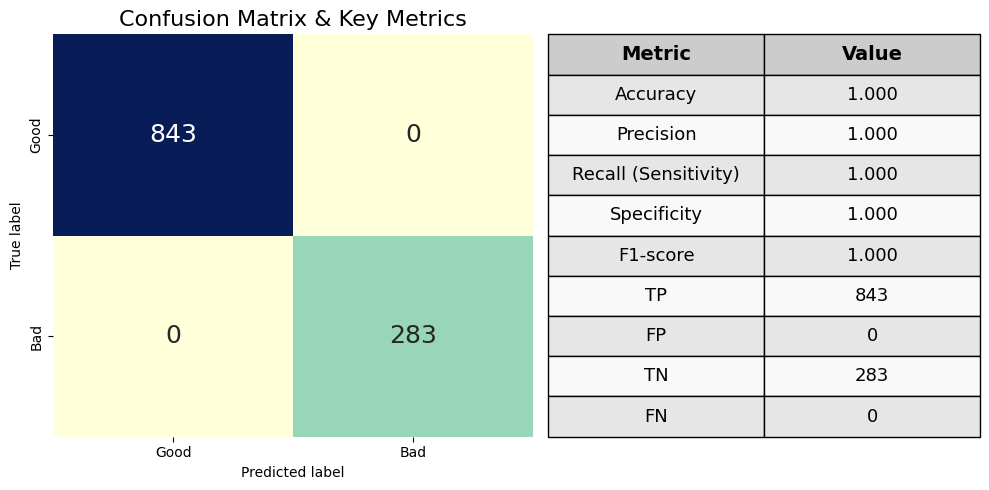

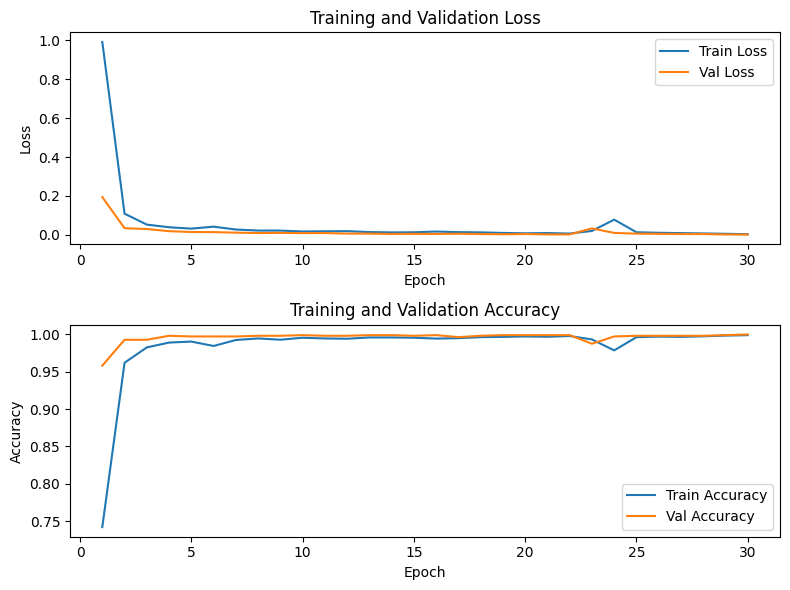

In [134]:
# ------------------------
#  Run Training & Evaluation
# ------------------------
# model = train_and_evaluate(train_loader, val_loader, test_loader)
best_model = train_and_evaluate(train_loader, val_loader, test_loader)



In [135]:
# Save the trained model
torch.save(best_model.state_dict(), "../cnn1d_model3.ckpt")
print("✅ Model saved to cnn1d_model3.ckpt")
best_model.to(device)
best_model.eval()  # Switch to evaluation mode
print("✅ Model loaded and ready for explanations")
print(f"✅ Model is structured as  \n {best_model}")


✅ Model saved to cnn1d_model3.ckpt
✅ Model loaded and ready for explanations
✅ Model is structured as  
 CNN1D_Wide(
  (conv1): Conv1d(3, 16, kernel_size=(25,), stride=(1,), padding=(12,))
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv1d(16, 32, kernel_size=(15,), stride=(1,), padding=(7,))
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv1d(32, 64, kernel_size=(9,), stride=(1,), padding=(4,))
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.2, inplace=False)
  (conv4): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout4): Dropout(p=0.2, inplace=False)
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_fea

In [15]:
# this is a training for non-normalized data
data_directory = "../data/final/new_selection/Selected_data_grouped_windowed_downsampled"
dataset = VibrationDataset(data_directory, augment_bad=False)

# Create a combined stratification key (label_operation)
stratify_key = [f"{lbl}_{op}" for lbl, op in zip(dataset.labels, dataset.operations)]

# Stratified split by both label and operation
train_idx, temp_idx = train_test_split(
    range(len(dataset)), test_size=0.3, stratify=stratify_key
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=[stratify_key[i] for i in temp_idx]
)

# Create Subset datasets
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Verify split sizes and label distribution
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")
print(f"Train good: {sum(dataset.labels[train_idx] == 0)}, Train bad: {sum(dataset.labels[train_idx] == 1)}")
print(f"Val good: {sum(dataset.labels[val_idx] == 0)}, Val bad: {sum(dataset.labels[val_idx] == 1)}")
print(f"Test good: {sum(dataset.labels[test_idx] == 0)}, Test bad: {sum(dataset.labels[test_idx] == 1)}")

# Class ratios
train_ratio = sum(dataset.labels[train_idx] == 0) / sum(dataset.labels[train_idx] == 1)
val_ratio = sum(dataset.labels[val_idx] == 0) / sum(dataset.labels[val_idx] == 1)
test_ratio = sum(dataset.labels[test_idx] == 0) / sum(dataset.labels[test_idx] == 1)
print(f"Class ratio (good/bad) - Train: {train_ratio:.2f}, Val: {val_ratio:.2f}, Test: {test_ratio:.2f}")

# Operation distribution
train_ops = Counter(dataset.operations[train_idx])
val_ops = Counter(dataset.operations[val_idx])
test_ops = Counter(dataset.operations[test_idx])
print(f"Train operations: {train_ops}")
print(f"Val operations: {val_ops}")
print(f"Test operations: {test_ops}")

# Creating DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train size: 5250, Val size: 1125, Test size: 1126
Train good: 3924, Train bad: 1326
Val good: 839, Val bad: 286
Test good: 843, Test bad: 283
Class ratio (good/bad) - Train: 2.96, Val: 2.93, Test: 2.98
Train operations: Counter({np.str_('OP06'): 806, np.str_('OP04'): 694, np.str_('OP10'): 568, np.str_('OP12'): 559, np.str_('OP02'): 551, np.str_('OP11'): 534, np.str_('OP08'): 442, np.str_('OP14'): 330, np.str_('OP01'): 321, np.str_('OP07'): 279, np.str_('OP05'): 166})
Val operations: Counter({np.str_('OP06'): 173, np.str_('OP04'): 148, np.str_('OP10'): 121, np.str_('OP12'): 120, np.str_('OP02'): 119, np.str_('OP11'): 114, np.str_('OP08'): 94, np.str_('OP14'): 71, np.str_('OP01'): 69, np.str_('OP07'): 60, np.str_('OP05'): 36})
Test operations: Counter({np.str_('OP06'): 173, np.str_('OP04'): 149, np.str_('OP10'): 122, np.str_('OP12'): 119, np.str_('OP02'): 118, np.str_('OP11'): 115, np.str_('OP08'): 95, np.str_('OP14'): 71, np.str_('OP01'): 69, np.str_('OP07'): 60, np.str_('OP05'): 35})


Using device: cuda
Epoch [1/30] - Train Loss: 144.8467, Train Acc: 0.6366 - Val Loss: 5.0411, Val Acc: 0.7476 
Epoch [2/30] - Train Loss: 4.6854, Train Acc: 0.7855 - Val Loss: 1.3178, Val Acc: 0.7947 
Epoch [3/30] - Train Loss: 4.2915, Train Acc: 0.7931 - Val Loss: 1.3314, Val Acc: 0.8480 
Epoch [4/30] - Train Loss: 1.6027, Train Acc: 0.8810 - Val Loss: 4.1001, Val Acc: 0.4996 
Epoch [5/30] - Train Loss: 1.0803, Train Acc: 0.8970 - Val Loss: 2.1595, Val Acc: 0.6498 
Epoch [6/30] - Train Loss: 0.9522, Train Acc: 0.8956 - Val Loss: 5.8767, Val Acc: 0.3502 
Epoch [7/30] - Train Loss: 0.7649, Train Acc: 0.9042 - Val Loss: 0.5933, Val Acc: 0.8756 
Epoch [8/30] - Train Loss: 1.5239, Train Acc: 0.8672 - Val Loss: 1.5890, Val Acc: 0.6587 
Epoch [9/30] - Train Loss: 0.6300, Train Acc: 0.9114 - Val Loss: 3.4874, Val Acc: 0.4187 
Epoch [10/30] - Train Loss: 0.4857, Train Acc: 0.9204 - Val Loss: 0.7643, Val Acc: 0.8000 
Epoch [11/30] - Train Loss: 0.4505, Train Acc: 0.9305 - Val Loss: 0.4574, Val 

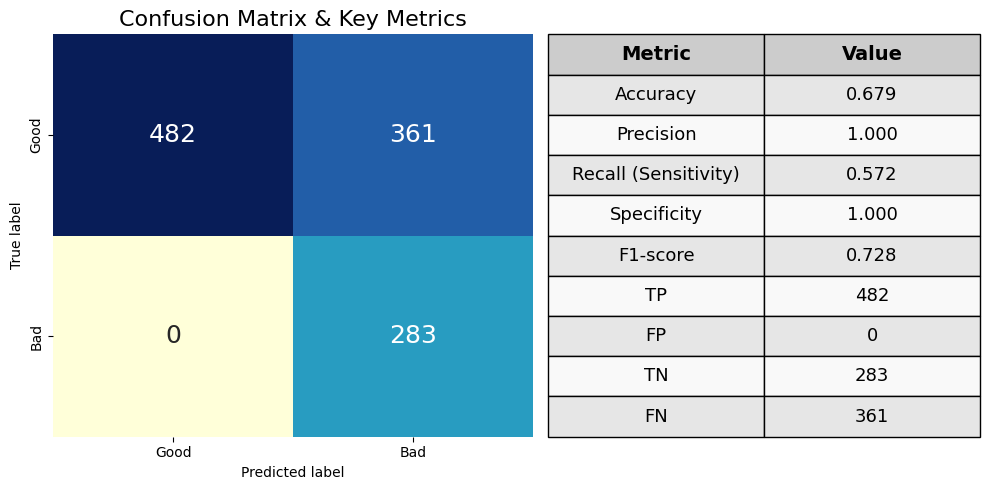

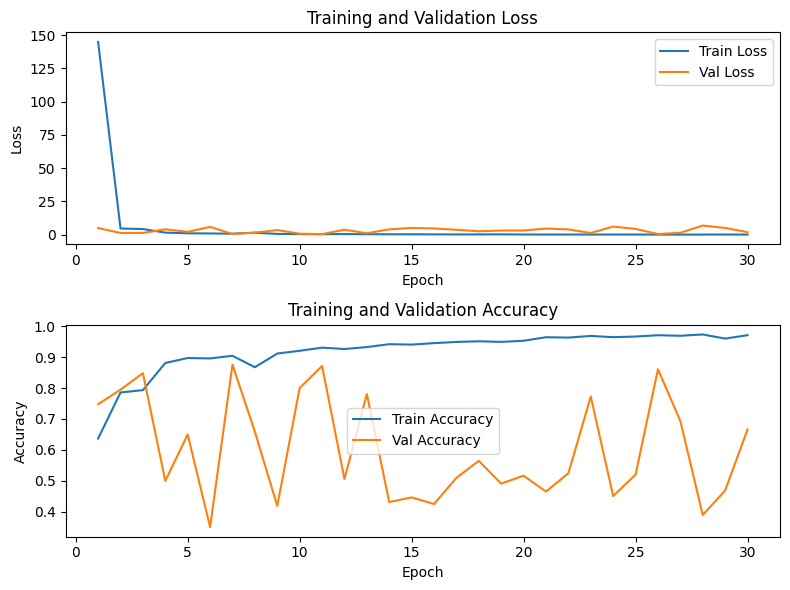

In [16]:
# ------------------------
#  Run Training & Evaluation for not normalized data
# ------------------------
# model = train_and_evaluate(train_loader, val_loader, test_loader)
best_model_unnormalized = train_and_evaluate(train_loader, val_loader, test_loader)



### Explain the Model

#### choose a good sample

In [145]:
# Load a Good sample

# Load a batch
sample_batch, label_batch = next(iter(test_loader))

random.seed(41)
# Choose a random index
random_index = random.randint(0, len(sample_batch) - 1)


# Select the random sample and its corresponding label
sample = sample_batch[random_index]  # Shape: (3, 10000)
label = label_batch[random_index]    # Shape: ()



sample = sample.to(device)
label = label.to(device)

_, predicted_label = predict_single(best_model, sample)


# Print the selected sample and label
print(f"Random Index: {random_index}, Predicted_label:{predicted_label}, True_label:{label}")
print(sample, sample.shape)


Random Index: 97, Predicted_label:0, True_label:0
tensor([[-1.0453, -0.7799, -0.5944,  ...,  2.9316,  2.6697,  2.1273],
        [ 0.1252, -0.0405,  0.0244,  ..., -1.6198, -1.5120, -1.1238],
        [ 0.0624, -0.3518, -0.1563,  ..., -0.3861, -0.0366,  0.3093]],
       device='cuda:0') torch.Size([3, 2000])


Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relevance hat shape after multiplication: torch.Size([1, 2000])
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relevance hat shape after multiplication: torch.Size([1, 2000])
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 200

E:\Thesis\Datasets\CNC\utils\dft_lrp.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=dtype)


Sample 97 Label: Good


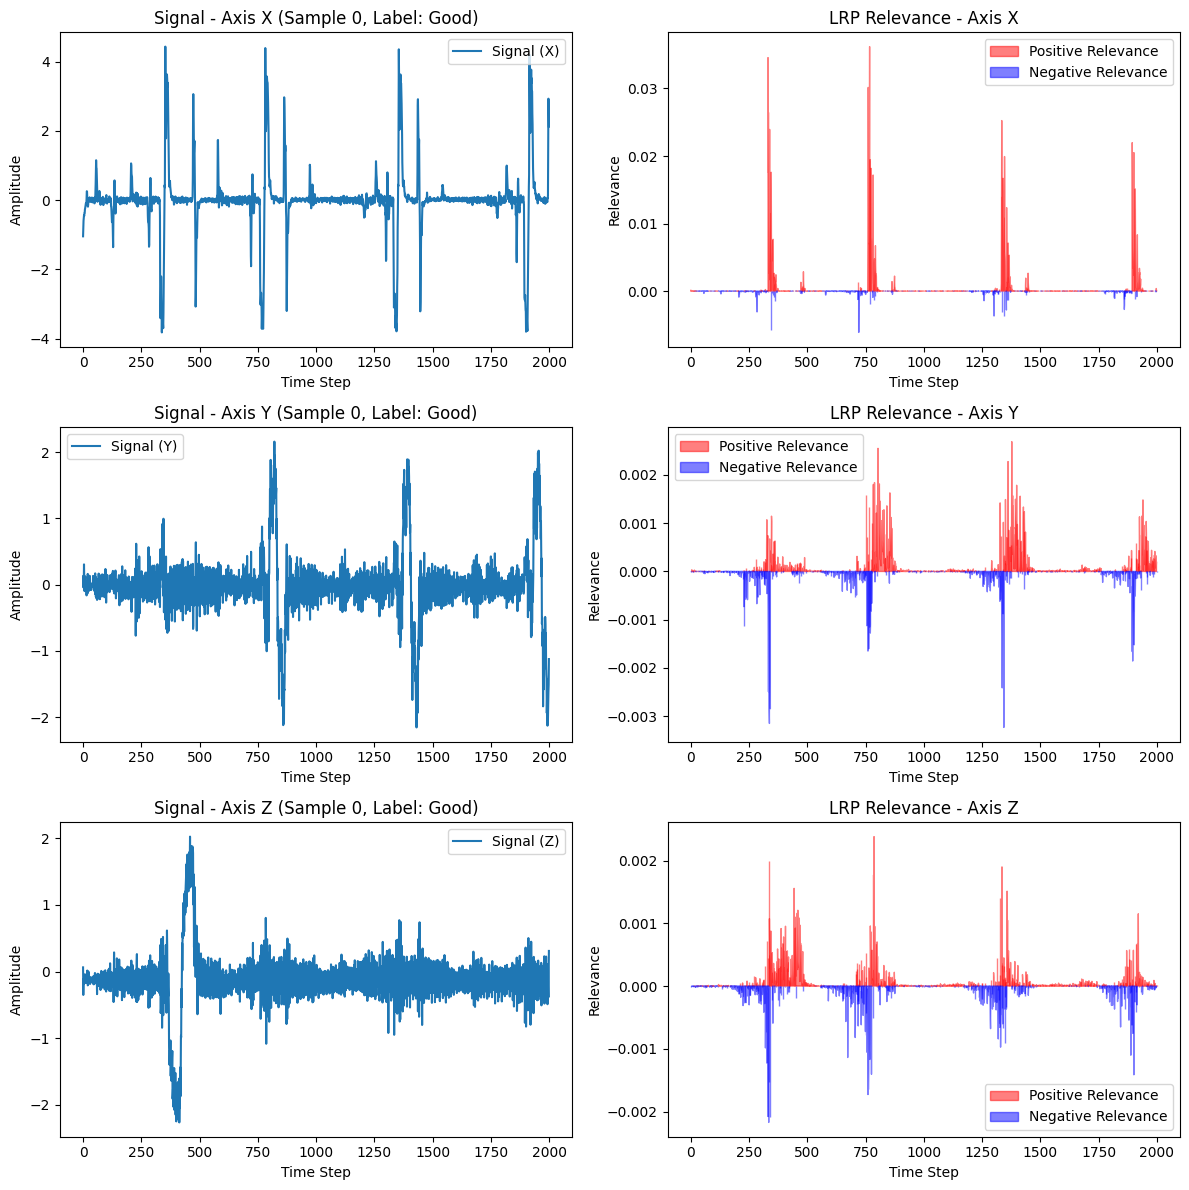

In [150]:
relevance_time, relevance_freq, signal_freq, input_signal, freqs, f_label = compute_dft_lrp_relevance(
    model=best_model,
    sample=sample,  # Shape: (3, 2000) or torch tensor
    label=label,  # Use true label or None for prediction
    device=device
)
print(f"Sample {random_index} Label: {'Good' if f_label == 0 else 'Bad'}")

# Visualize LRP relevances (use your existing `visualize_lrp_relevance_single_sample` function)
visualize_lrp_single_sample(
    signal=input_signal,
    relevance=relevance_time,
    label=f_label)

Sample device: cuda:0
Model device: cuda:0
Target device: cuda:0
Sample 97 Label: Good


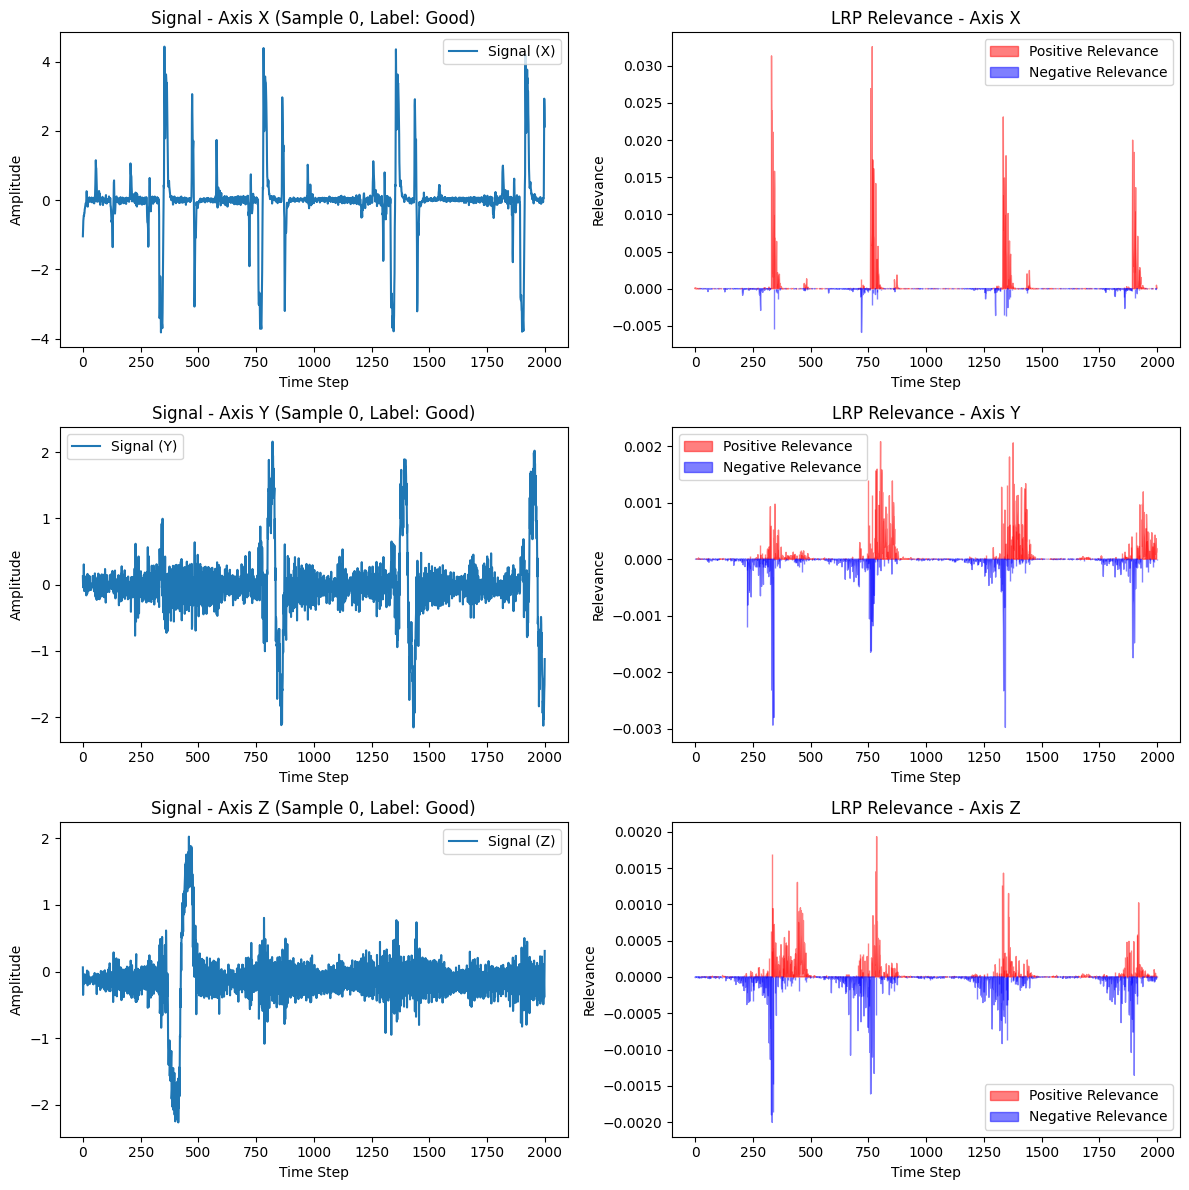

In [151]:
relevance, input_signal, final_label = compute_lrp_relevance(
    model=best_model,
    sample=sample,  # Shape: (3, 10000) or torch tensor
    label=label,  # Use true label or None for prediction
    device=device
)
print(f"Sample {random_index} Label: {'Good' if final_label == 0 else 'Bad'}")

# Visualize LRP relevances (use your existing `visualize_lrp_relevance_single_sample` function)
visualize_lrp_single_sample(
    signal=input_signal,
    relevance=relevance,
    label=final_label)

#### DFT-LRP implementation

In [148]:
relevance_time, relevance_freq, signal_freq, input_signal, freqs, predicted_label = compute_dft_lrp_relevance(
        model=best_model,
        sample=sample.cpu().detach().numpy(),  # Convert to NumPy for DFTLRP
        label=label.item(),
        device=device,
        signal_length=2000,   #10000 if we did not downsample
        sampling_rate=400  # Placeholder, replace with your actual sampling rate     #2000 if we did not downsample
    )

Input device in zennit_relevance_lrp: cuda:0
Error in zennit_relevance: One of the differentiated Tensors does not require grad


RuntimeError: One of the differentiated Tensors does not require grad

Min relevance: -0.12017683684825897, Max relevance: 0.2137136459350586
 Maximum Absolute Attribution in Axis 0: 0.2137136459350586
 Maximum Absolute Attribution in Axis 1: 0.07394641637802124
 Maximum Absolute Attribution in Axis 2: 0.03514261543750763


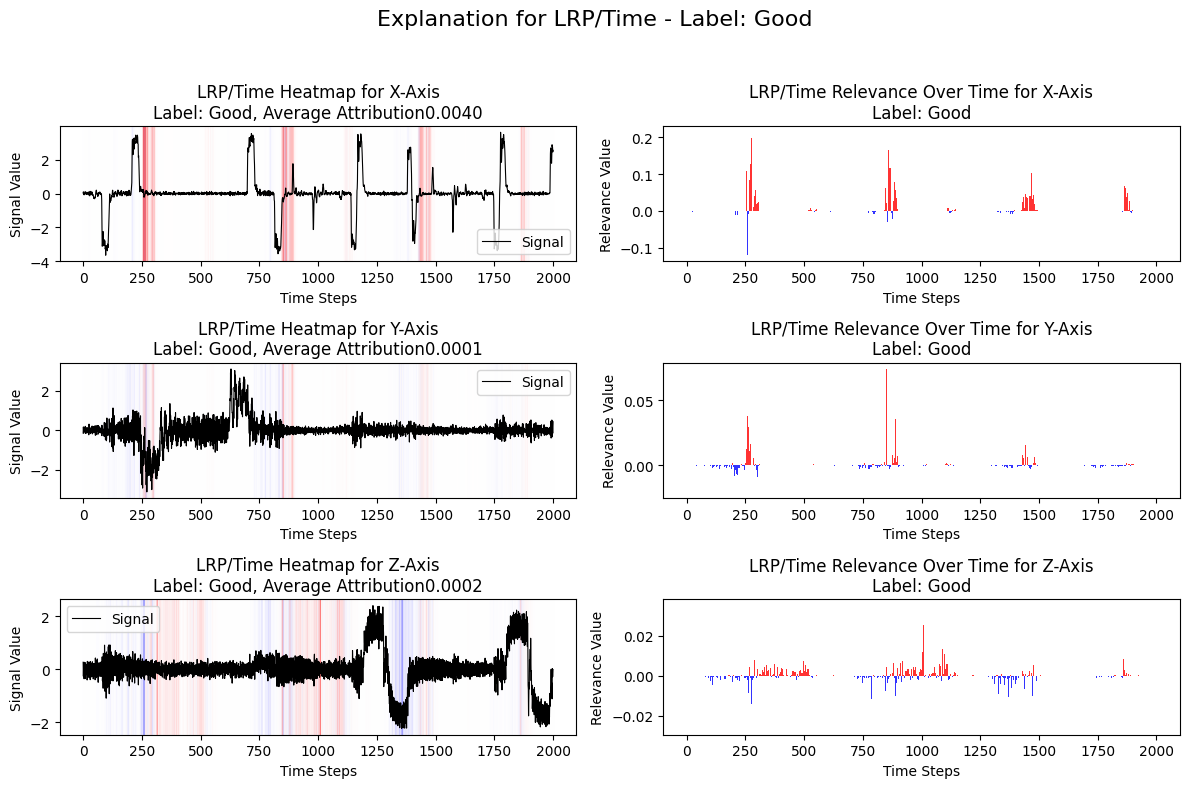

In [141]:
# LRP visualization with mutual visualization function
print(f"Min relevance: {np.min(relevance_time)}, Max relevance: {np.max(relevance_time)}")
visualize_with_label_attribution(sample, relevance_time, label, "LRP/Time")


In [93]:
""# Global Attribution over frequency with LRP
summary_lrp_freq = summarize_attributions(relevance_freq)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_lrp_freq = []
for axis, values in summary_lrp_freq.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp_freq.append(row)

# Create the DataFrame
df_summary_lrp_freq = pd.DataFrame(data_lrp_freq)

# Display the DataFrame as a table
print(df_summary_lrp_freq)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             562                  8.705377   
1  Axis 1             503                  1.223694   
2  Axis 2             438                  2.606641   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.015490             439                 -0.725269   
1                    0.002433             498                 -0.994958   
2                    0.005951             563                 -2.274897   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.001652                     7.980109   
1                   -0.001998                     0.228737   
2                   -0.004041                     0.331744   

   Average Relevance (Pos + Neg)  
0                       0.007972  
1                       0.000229  
2                       0.000331  


In [94]:
""# Global Attribution over frequency with LRP
summary_lrp_t = summarize_attributions(relevance_time)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_lrp_t = []
for axis, values in summary_lrp_t.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp_t.append(row)

# Create the DataFrame
df_summary_lrp_t = pd.DataFrame(data_lrp_t)

# Display the DataFrame as a table
print(df_summary_lrp_t)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1115                  9.125391   
1  Axis 1             998                  0.983941   
2  Axis 2             990                  1.514065   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.008184             885                 -1.142349   
1                    0.000986            1002                 -0.847380   
2                    0.001529            1010                 -1.184213   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.001291                     7.983042   
1                   -0.000846                     0.136562   
2                   -0.001172                     0.329852   

   Average Relevance (Pos + Neg)  
0                       0.003992  
1                       0.000068  
2                       0.000165  


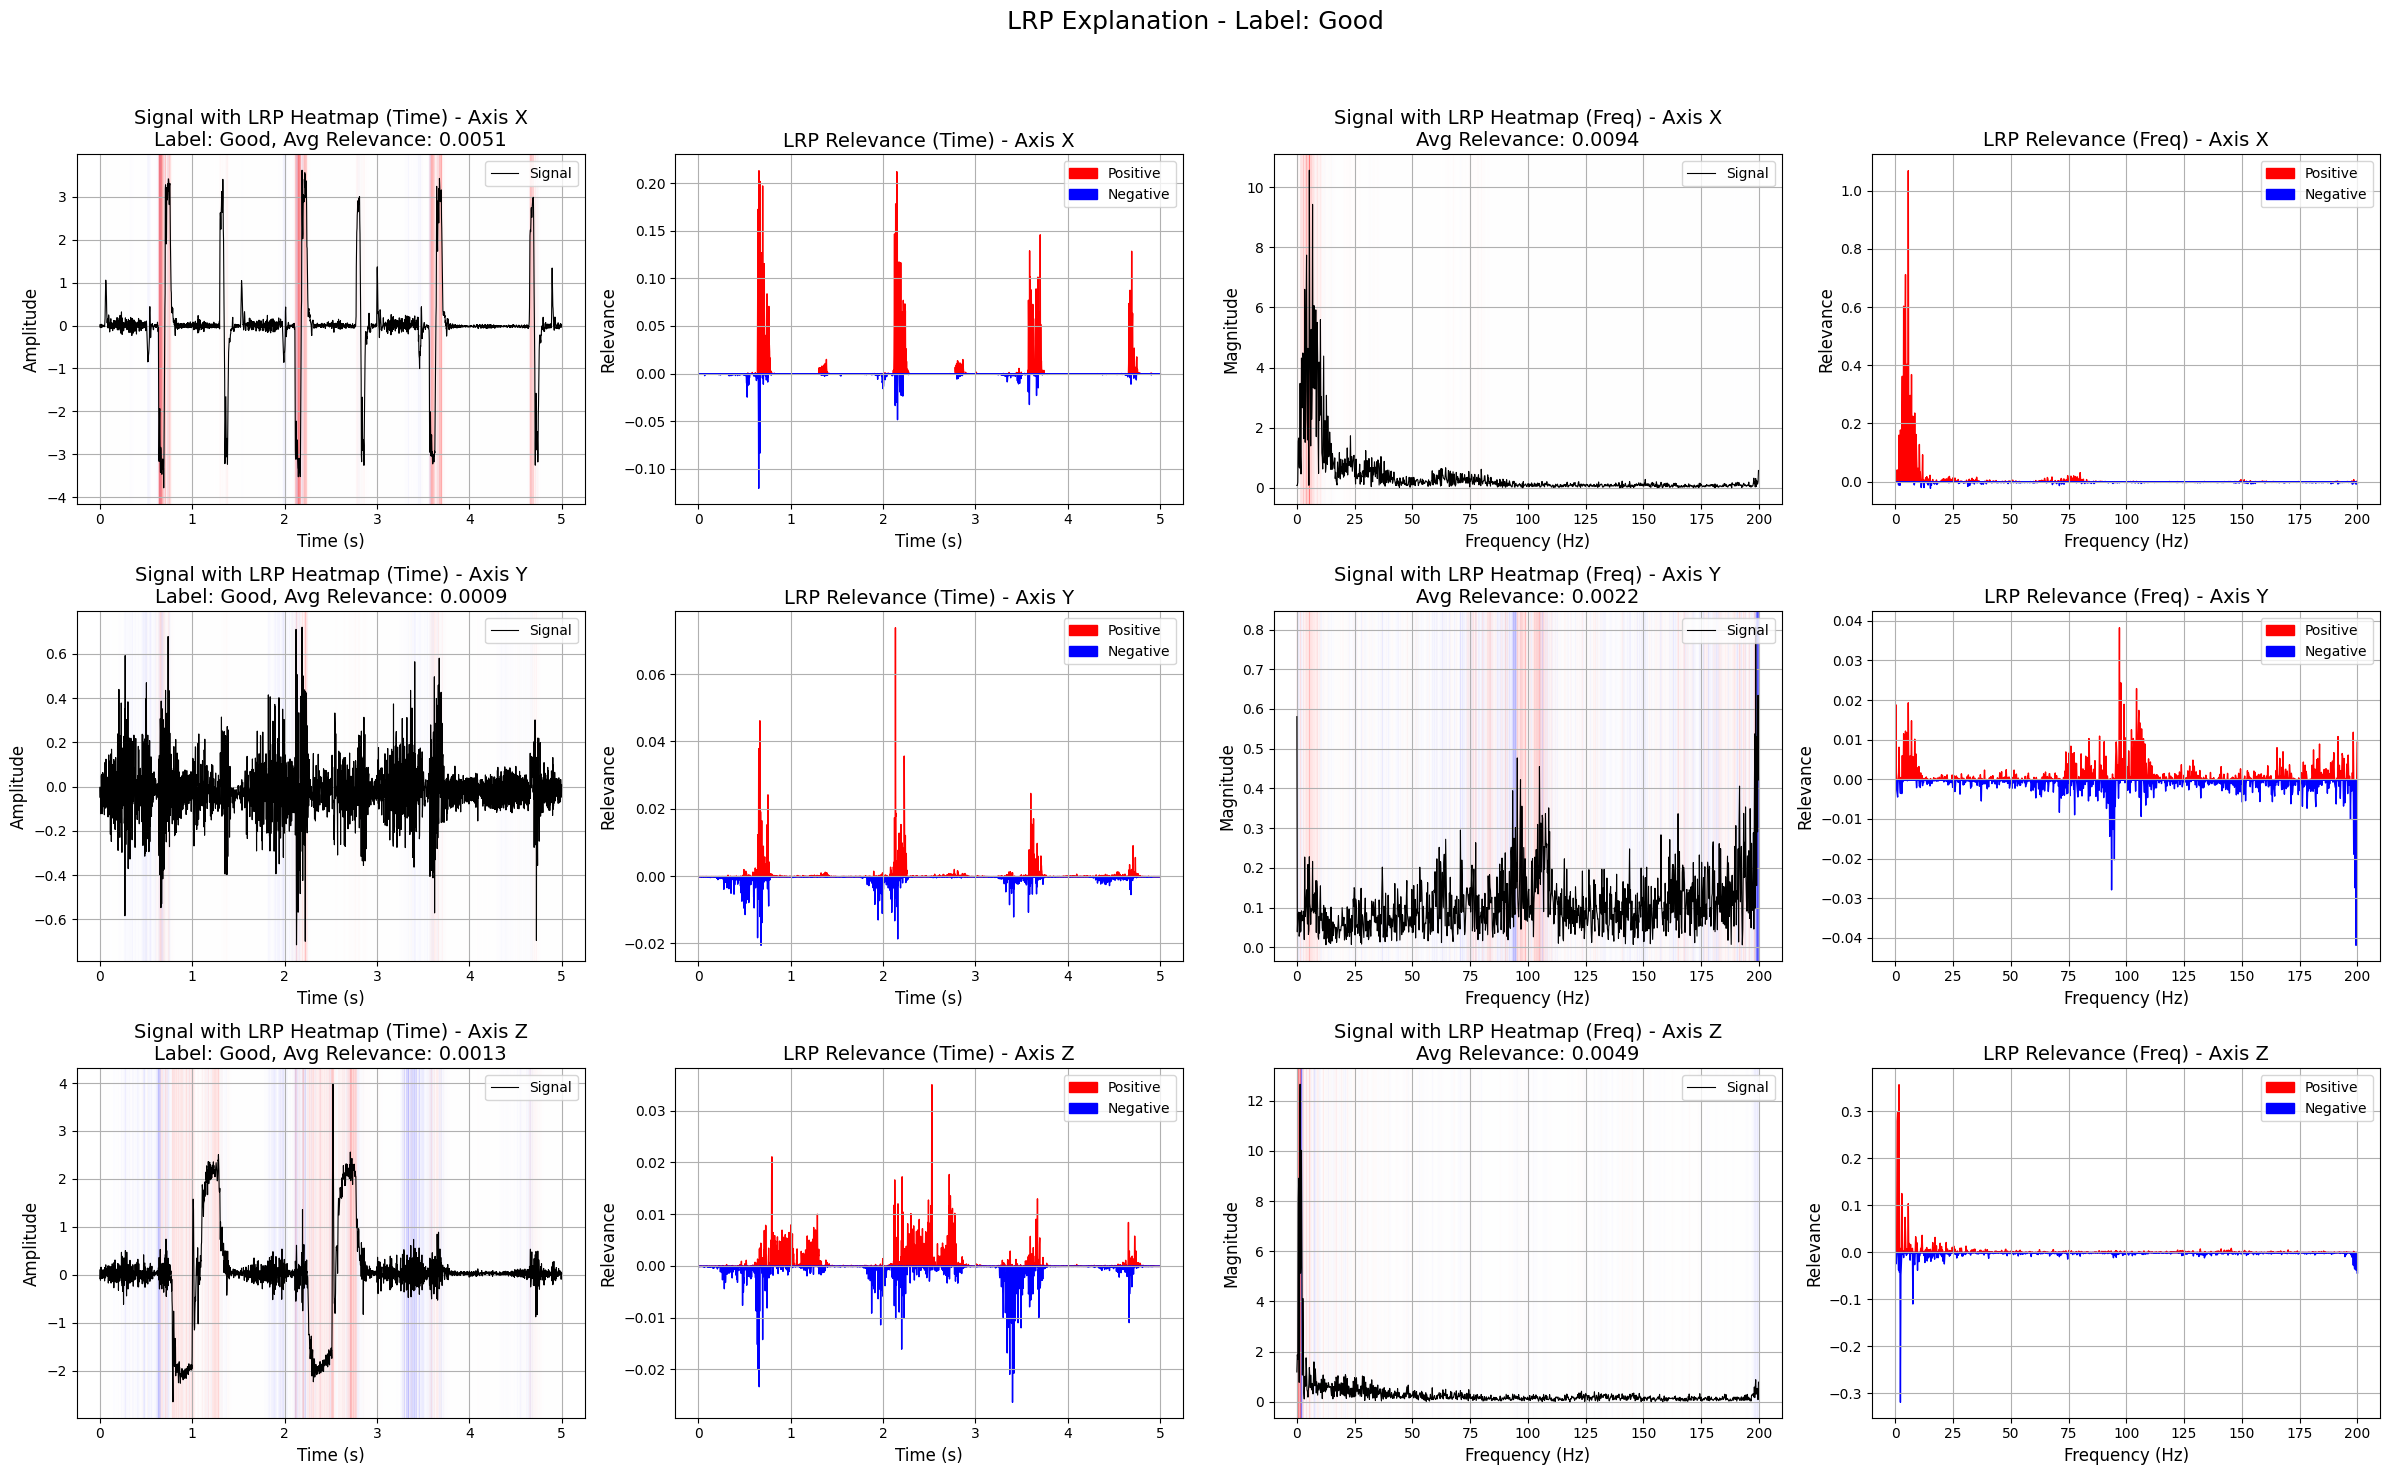

In [95]:
# Visualize the results
visualize_lrp_dft(
        relevance_time=relevance_time,
        relevance_freq=relevance_freq,
        signal_freq=signal_freq,
        input_signal=input_signal,
        freqs=freqs,
        predicted_label=predicted_label,
        k_max=1000,  # Plot up to 1000 Hz
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

In [31]:
# LRP visualization with common visualization function
 # write something similar to the common visualization for the frequency, so the relevance are colored over fft/dft signals
# in compute_dft_lrp_relevance why freqs are calculated by fft not dft?

In [96]:
import gc

# Before calling your function
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()


499051

In [97]:
relevance_time_dft, relevance_freq_dft, signal_freq_dft, relevance_timefreq_dft, signal_timefreq_dft, input_signal_dft, freqs_dft, predicted_label_dft = compute_dft_lrp_relevance_with_timefreq(
        model=best_model,
        sample=sample,
        label=None,
        signal_length=2000,
        sampling_rate=400,
        window_shift=128,  # Increased to reduce memory usage
        window_width=256,
        window_shape="rectangle"
    )

Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relevance hat shape after multiplication: torch.Size([1, 2000])


E:\Thesis\Datasets\CNC\utils\dft_lrp.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=dtype)


Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relevance hat shape after multiplication: torch.Size([1, 2000])
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weigh

In [98]:
import gc

# Before calling your function
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()


0

Error plotting time-frequency data for axis 0: too many indices for array: array is 2-dimensional, but 3 were indexed
Error plotting time-frequency data for axis 1: too many indices for array: array is 2-dimensional, but 3 were indexed
Error plotting time-frequency data for axis 2: too many indices for array: array is 2-dimensional, but 3 were indexed


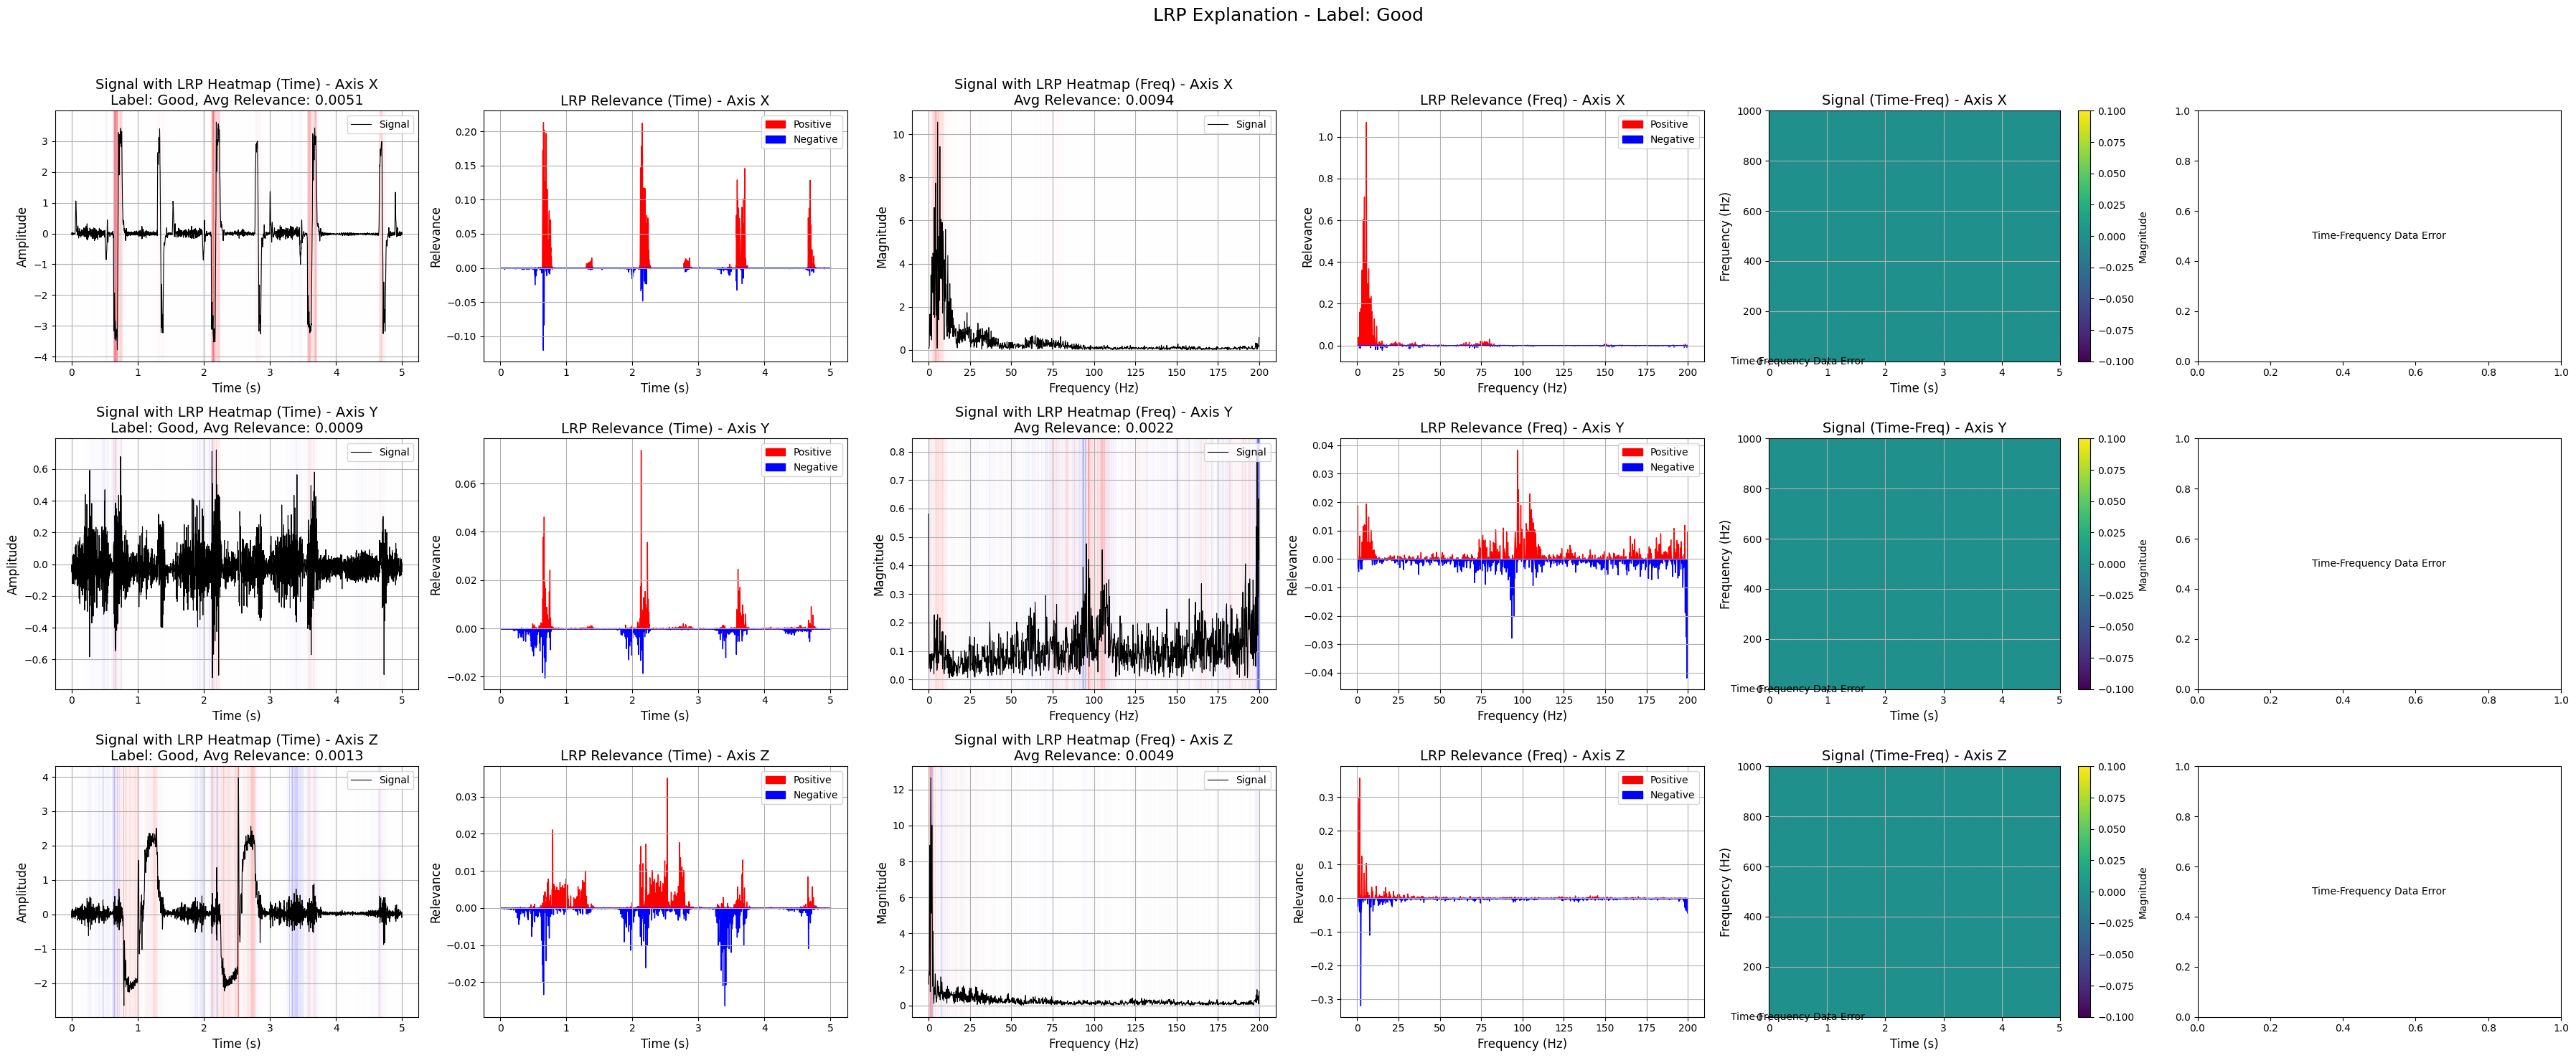

In [99]:
# Visualize the results
visualize_lrp_dft_extended(
        relevance_time=relevance_time_dft,
        relevance_freq=relevance_freq_dft,
        signal_freq=signal_freq_dft,
        relevance_timefreq=relevance_freq_dft,
        signal_timefreq=signal_timefreq_dft,
        input_signal=input_signal_dft,
        freqs=freqs_dft,
        predicted_label=predicted_label_dft,
        k_max=1000,  # Plot up to 1000 Hz
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

#### FFT-LRP implementation

In [100]:
relevance_time_fft, relevance_freq_fft, signal_freq_fft, relevance_timefreq_fft, signal_timefreq_fft, input_signal_fft, freqs_fft, predicted_label_fft = compute_fft_lrp_relevance(
        model=best_model,
        sample=sample,
        label=None,
        signal_length=2000,
        sampling_rate=400,
        compute_timefreq=True,
        window_shift=64,  # Increased to reduce memory usage
        window_width=128,
        window_shape="rectangle"
    )

Input sample shape: torch.Size([1, 3, 2000])
Target label: 0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
relevance_time_tensor shape before squeeze: (1, 3, 2000)
relevance_time shape after squeeze: (3, 2000)
input_signal shape: (3, 2000)
fft_lrp: Input relevance shape = (1, 2000), signal shape = (1, 2000)
fft_lrp: relevance_tensor shape = torch.Size([1, 2000]), signal_tensor shape = torch.Size([1, 2000])
fourier_transform: signal_tensor shape = torch.Size([1, 2000])
fourier_transform (FFT): signal_hat shape = torch.Size([1, 1001])
fft_lrp: signal_hat shape = torch.Size([1, 1001])
fft_lrp: relevance_normed shape = torch.Size([1, 2000])
fft_lrp: relevance_fft real part = tensor([[ 0.0034,  0.0135,  0.0049,  ...,  0.0156,  0.0188, -0.0052]],
       device='cuda:0')
fft_lrp: relevance_fft imag part = tensor([[ 0.0000,  0.0109,  0.0157,  ..., -0.0106,  0.0047,  0.0000]],
       device='cuda:0')
fft_lrp: relevance_hat real part before cpu = tensor([[

In [101]:
# Global Attribution for FFT_LRP over frequency
summary_fft_freq = summarize_attributions(relevance_freq_fft)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_fft_freq = []
for axis, values in summary_fft_freq.items():
    row = {"Axis": axis}
    row.update(values)
    data_fft_freq.append(row)

# Create the DataFrame
df_summary_fft_freq = pd.DataFrame(data_fft_freq)

# Display the DataFrame as a table
print(df_summary_fft_freq)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             563        3.989094+0.000000j   
1  Axis 1             502        4.586784+0.000000j   
2  Axis 2             438        2.402157+0.000000j   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0          0.007085+0.000000j             438       -2.323455+0.000000j   
1          0.009137+0.000000j             499       -4.032140+0.000000j   
2          0.005484+0.000000j             563       -3.320024+0.000000j   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0         -0.005305+0.000000j           1.665639+0.000000j   
1         -0.008080+0.000000j           0.554644+0.000000j   
2         -0.005897+0.000000j          -0.917867+0.000000j   

   Average Relevance (Pos + Neg)  
0             0.001664+0.000000j  
1             0.000554+0.000000j  
2            -0.000917+0.000000j  


In [102]:
# Global Attribution for FFT_LRP over time frequency
summary_fft_timefreq = summarize_attributions(relevance_timefreq_fft)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_fft_timefreq = []
for axis, values in summary_fft_timefreq.items():
    row = {"Axis": axis}
    row.update(values)
    data_fft_timefreq.append(row)

# Create the DataFrame
df_summary_fft_timefreq = pd.DataFrame(data_fft_timefreq)

# Display the DataFrame as a table
print(df_summary_fft_timefreq)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0           10714      14.249589+ 0.000000j   
1  Axis 1           10867      15.753419+ 0.000000j   
2  Axis 2           10581       8.290801+ 0.000000j   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0          0.001330+0.000000j            9306      -8.151214+ 0.000000j   
1          0.001450+0.000000j            9153     -13.573017+ 0.000000j   
2          0.000784+0.000000j            9439     -11.993959+ 0.000000j   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0         -0.000876+0.000000j           6.098375+0.000000j   
1         -0.001483+0.000000j           2.180402+0.000000j   
2         -0.001271+0.000000j          -3.703159+0.000000j   

   Average Relevance (Pos + Neg)  
0             0.000305+0.000000j  
1             0.000109+0.000000j  
2            -0.000185+0.000000j  


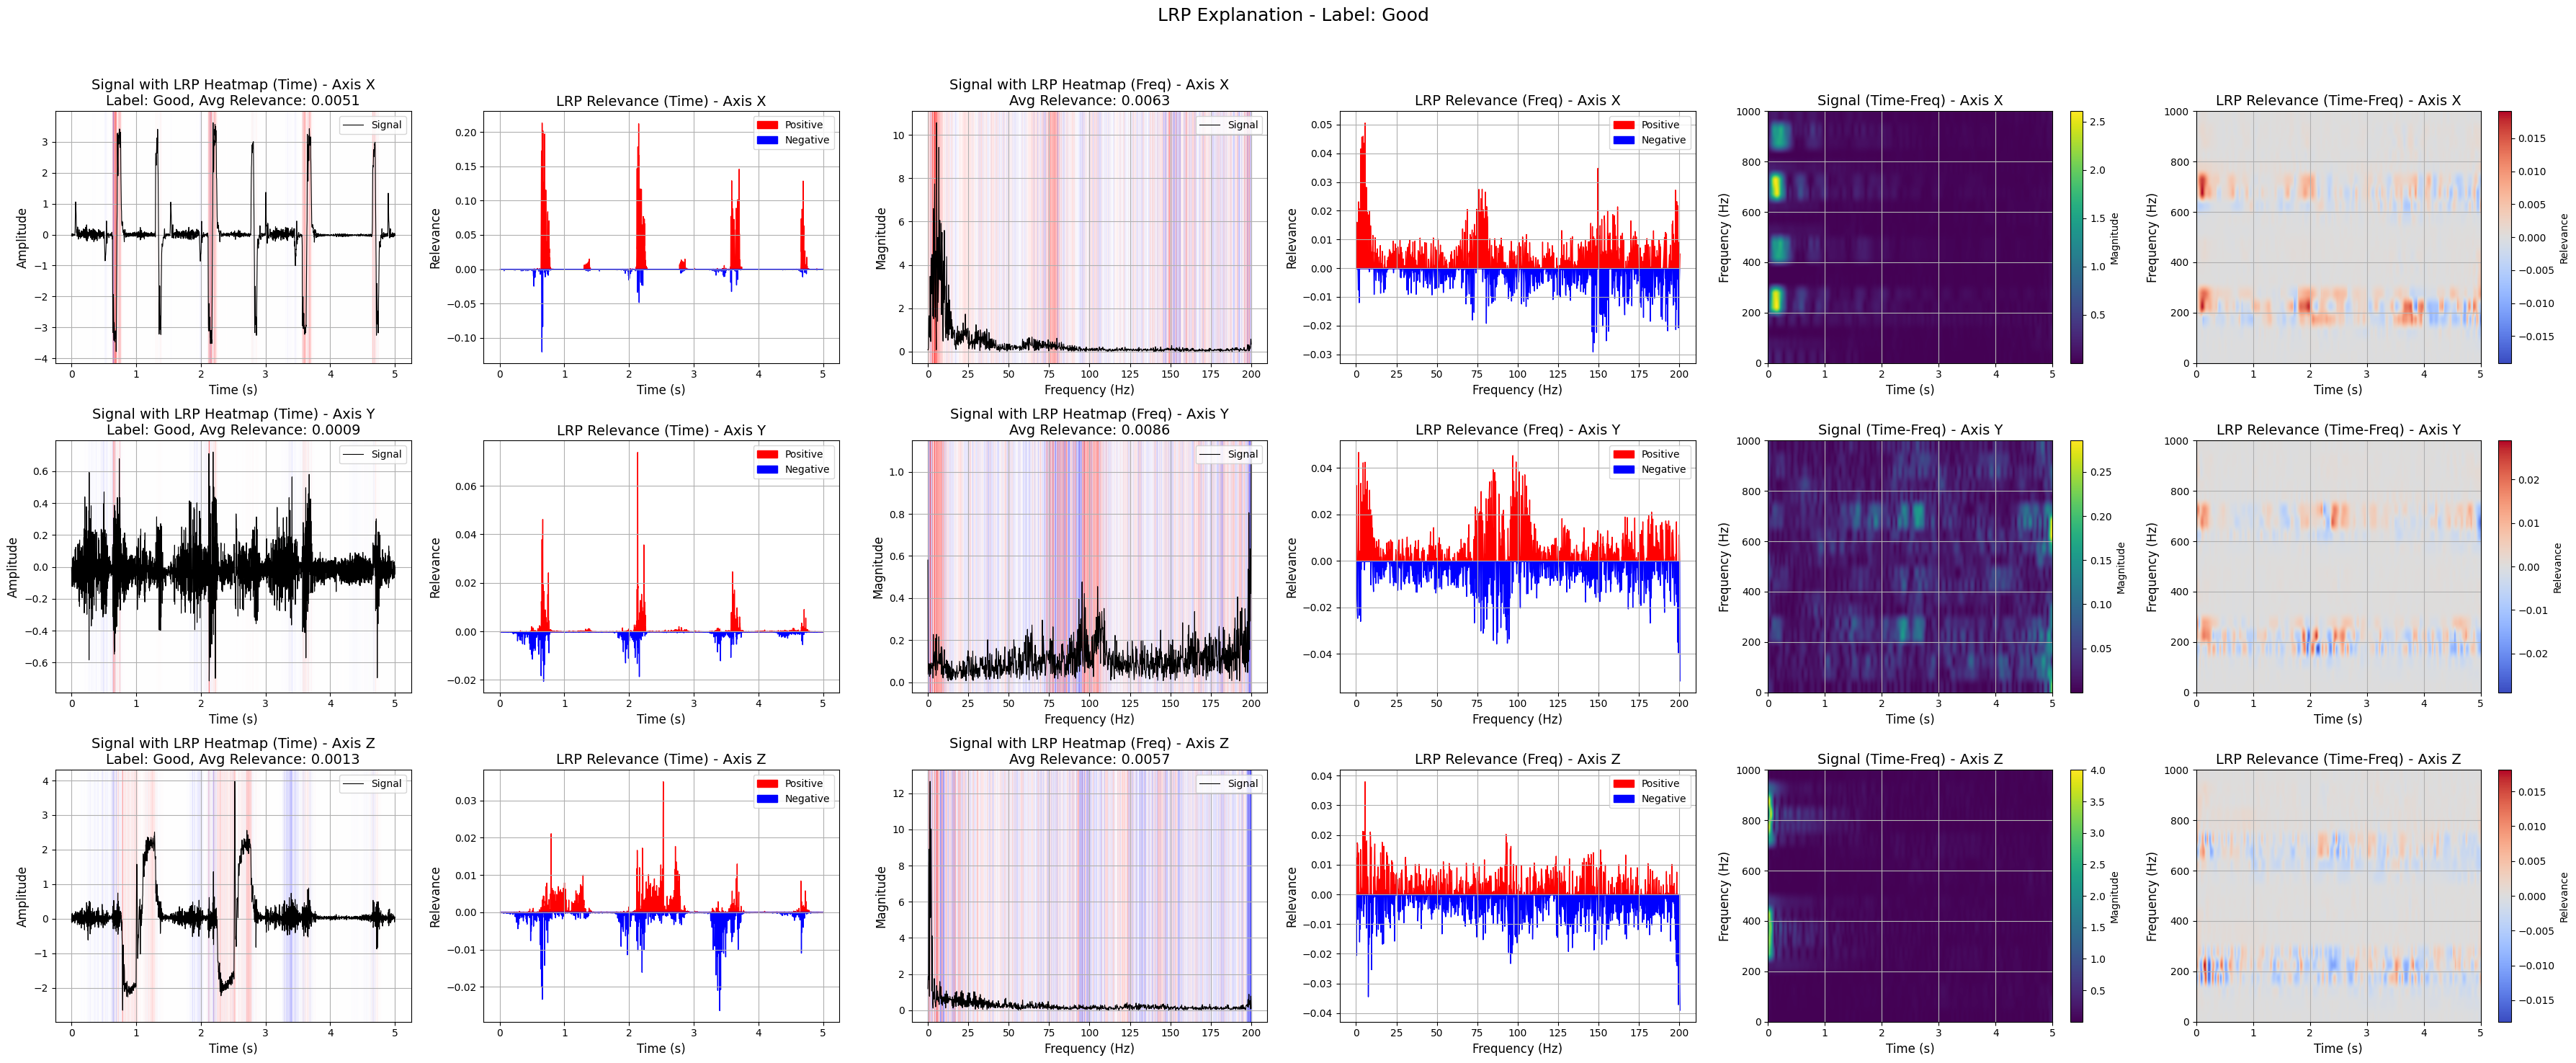

In [103]:
# Visualize
visualize_lrp_fft(
    relevance_time=relevance_time_fft,
    relevance_freq=relevance_freq_fft,
    signal_freq=signal_freq_fft,
    relevance_timefreq=relevance_timefreq_fft,
    signal_timefreq=signal_timefreq_fft,
    input_signal=input_signal_fft,
    freqs=freqs_fft,
    predicted_label=predicted_label_fft,
    signal_length=2000,
    sampling_rate=400,
    k_max=1000
)

Min relevance: -1.386168360710144, Max relevance: 2.237823486328125
 Maximum Absolute Attribution in Axis 0: 2.237823486328125
 Maximum Absolute Attribution in Axis 1: 0.5601271986961365
 Maximum Absolute Attribution in Axis 2: 0.717510461807251


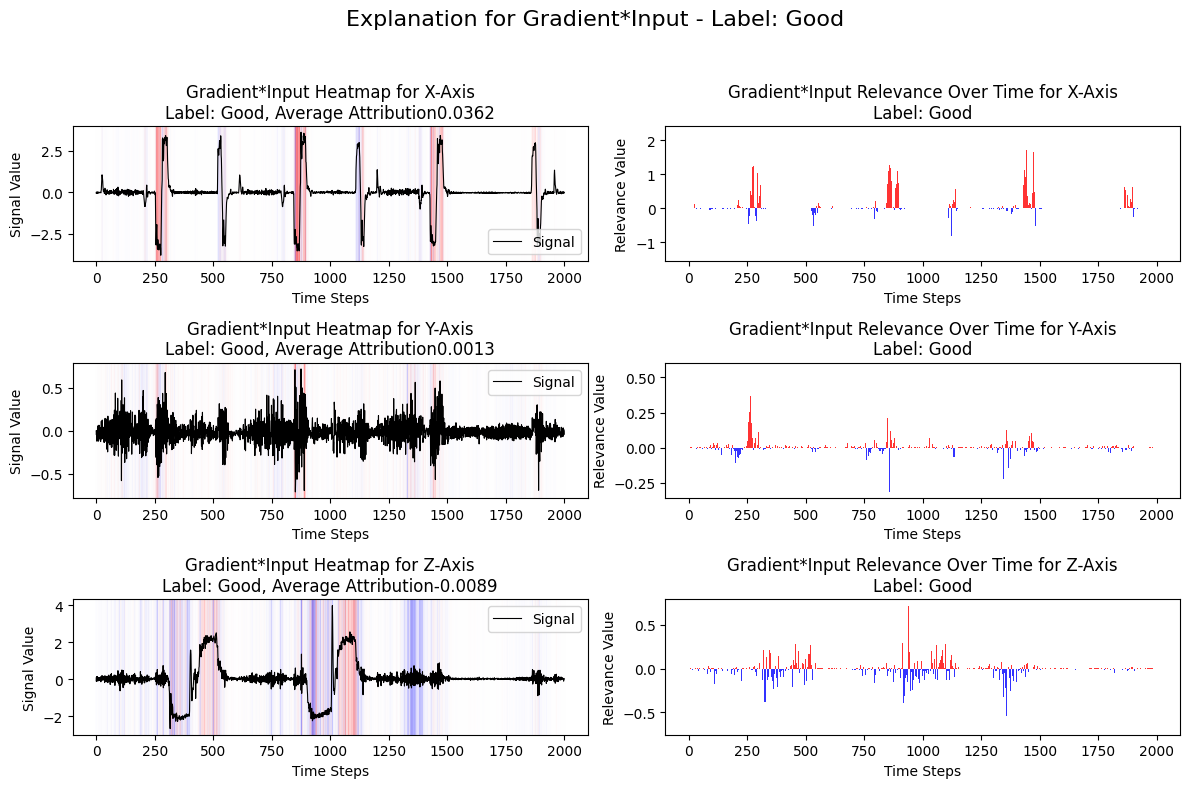

In [104]:
# Grad*Input
grad_input_attr, _ = grad_times_input_relevance(best_model, sample)

print(f"Min relevance: {np.min(grad_input_attr.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, grad_input_attr, label, "Gradient*Input")


In [105]:
# Example usage
summary_g = summarize_attributions(grad_input_attr.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_g = []
for axis, values in summary_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_g.append(row)

# Create the DataFrame
df_summary_g = pd.DataFrame(data_g)

# Display the DataFrame as a table
print(df_summary_g)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1007                110.149658   
1  Axis 1            1038                 16.254581   
2  Axis 2             900                 33.494713   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.109384             993                -37.737312   
1                    0.015660             962                -13.679686   
2                    0.037216            1100                -51.274395   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.038003                    72.412346   
1                   -0.014220                     2.574896   
2                   -0.046613                   -17.779682   

   Average Relevance (Pos + Neg)  
0                       0.036206  
1                       0.001287  
2                      -0.008890  


Min relevance: -0.8121269345283508, Max relevance: 0.3454192578792572
 Maximum Absolute Attribution in Axis 0: 0.8121269345283508
 Maximum Absolute Attribution in Axis 1: 0.18263481557369232
 Maximum Absolute Attribution in Axis 2: 0.270210325717926


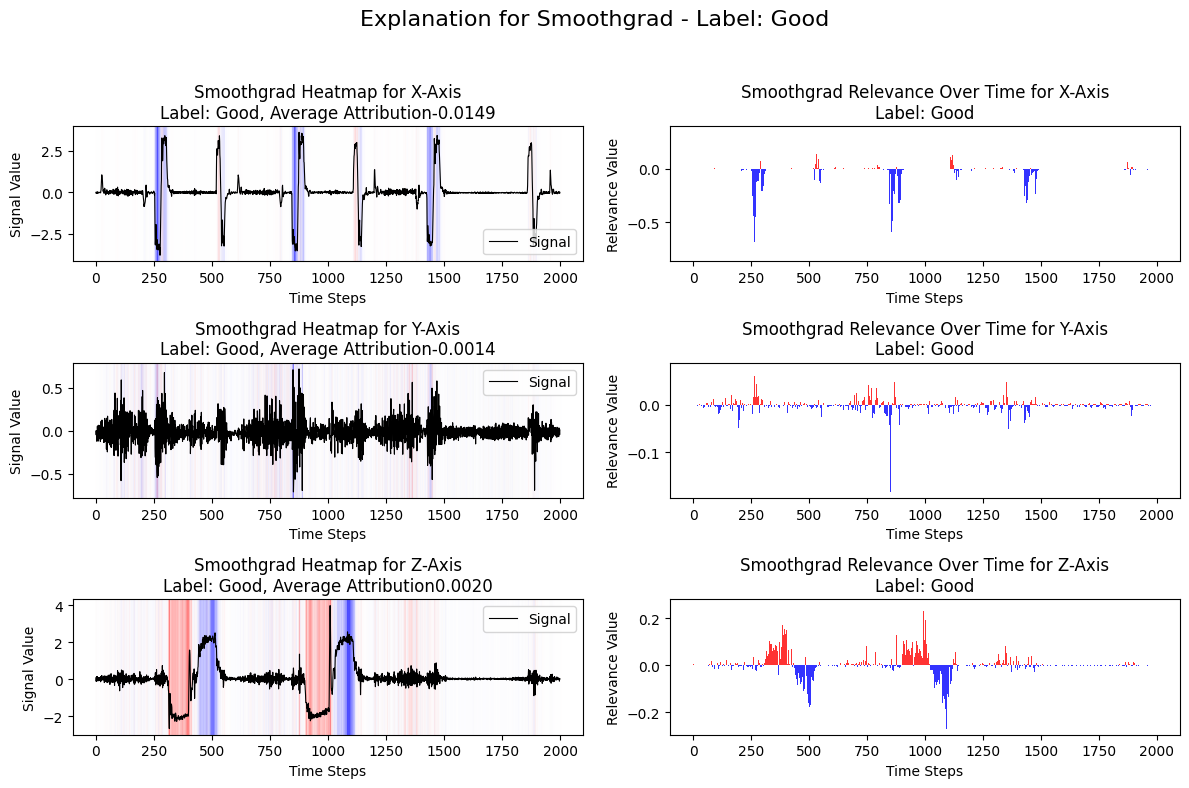

In [106]:

# SmoothGrad
smoothgrad_attr, _ = smoothgrad_relevance(best_model, sample)
print(f"Min relevance: {np.min(smoothgrad_attr.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, smoothgrad_attr, label, "Smoothgrad")


Min relevance: -0.07210922241210938, Max relevance: 0.42126941680908203
 Maximum Absolute Attribution in Axis 0: 0.42126941680908203
 Maximum Absolute Attribution in Axis 1: 0.058135986328125
 Maximum Absolute Attribution in Axis 2: 0.07613563537597656


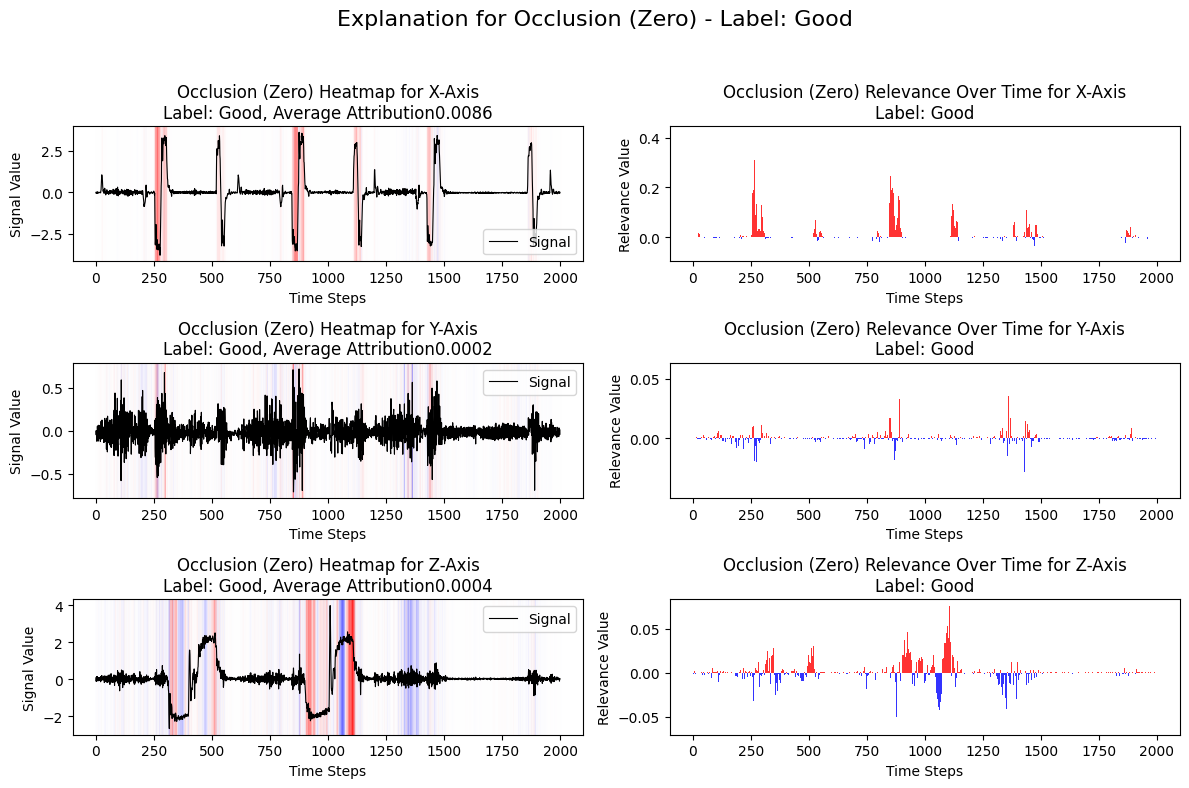

In [107]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero, _ = occlusion_signal_relevance(best_model, sample, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero, label, "Occlusion (Zero)")


Min relevance: -0.5785160064697266, Max relevance: 2.644209861755371
 Maximum Absolute Attribution in Axis 0: 2.644209861755371
 Maximum Absolute Attribution in Axis 1: 2.644209861755371
 Maximum Absolute Attribution in Axis 2: 2.644209861755371


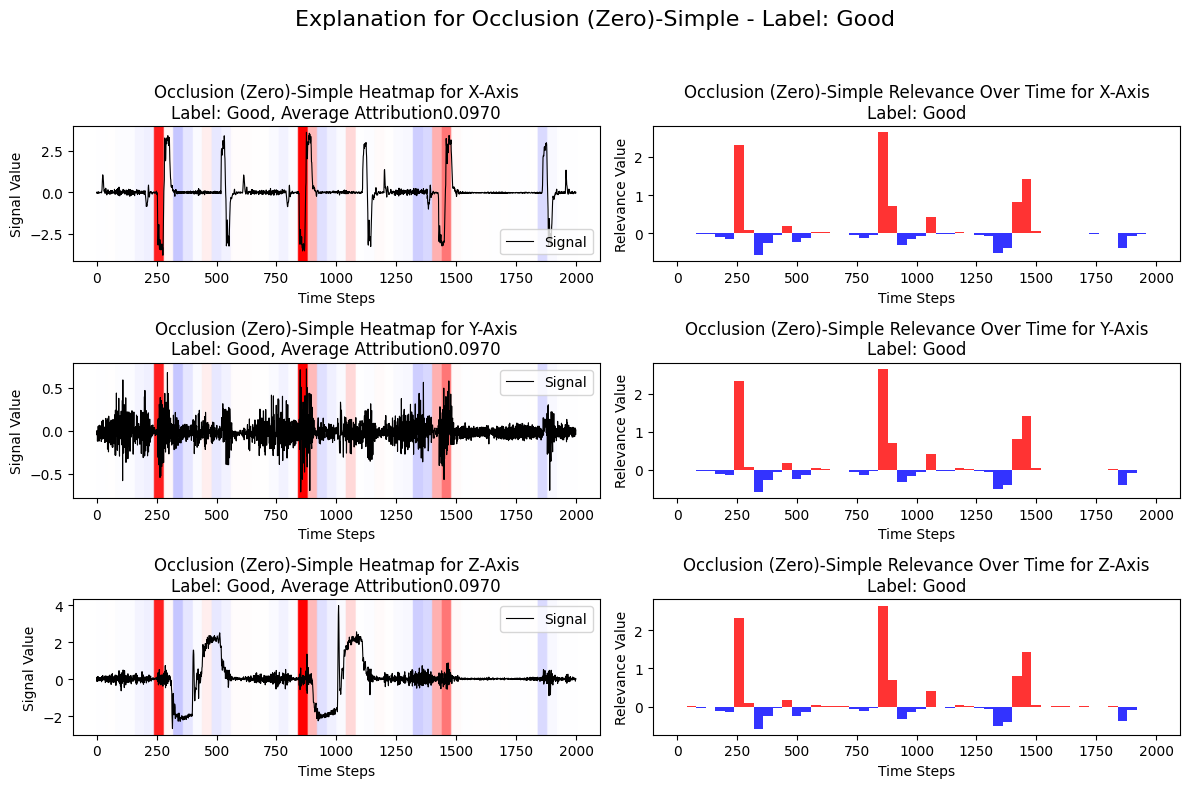

In [108]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_simple, _ = occlusion_simpler_relevance(best_model, sample, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_simple.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_simple.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero_simple, label, "Occlusion (Zero)-Simple")


Min relevance: -1.4970502853393555, Max relevance: 1.9927825927734375
 Maximum Absolute Attribution in Axis 0: 1.9927825927734375
 Maximum Absolute Attribution in Axis 1: 1.9927825927734375
 Maximum Absolute Attribution in Axis 2: 1.9927825927734375


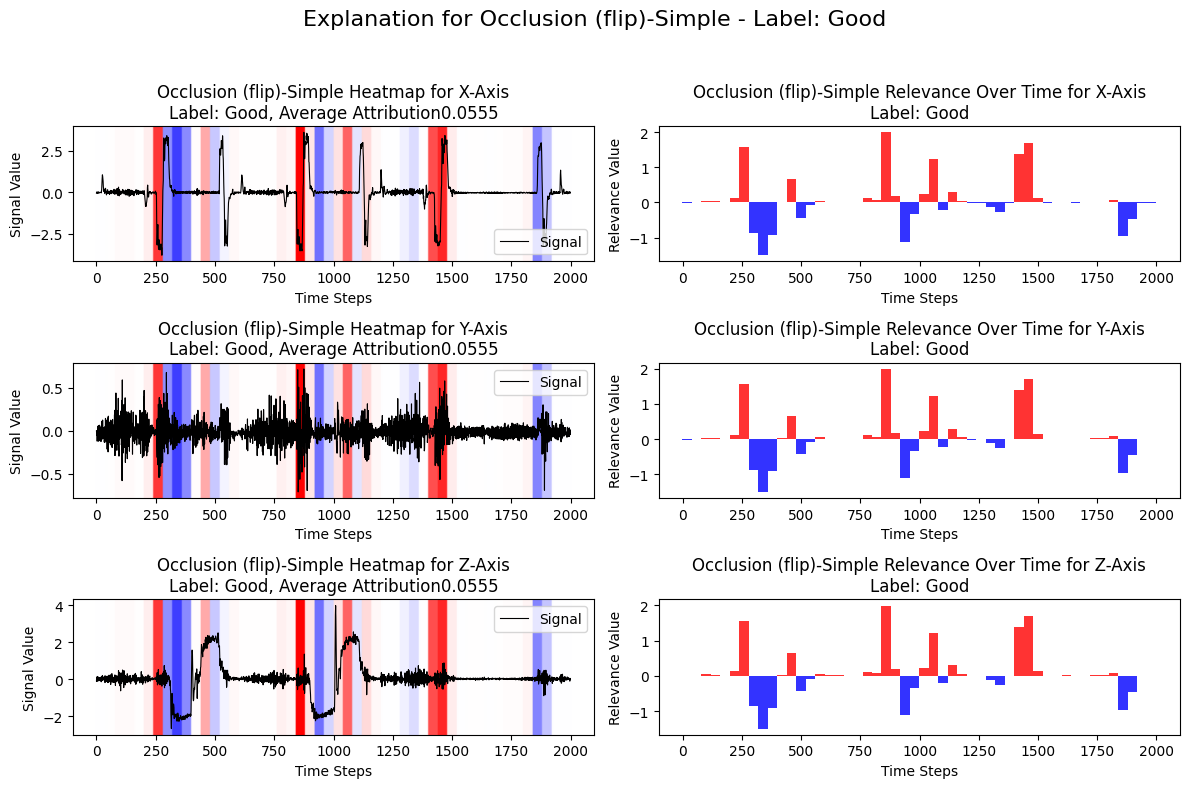

In [109]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_simple, _ = occlusion_simpler_relevance(best_model, sample, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_zero_simple.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_simple.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero_simple, label, "Occlusion (flip)-Simple")


Min relevance: -0.14898109436035156, Max relevance: 0.5810937881469727
 Maximum Absolute Attribution in Axis 0: 0.5810937881469727
 Maximum Absolute Attribution in Axis 1: 0.16367244720458984
 Maximum Absolute Attribution in Axis 2: 0.14898109436035156


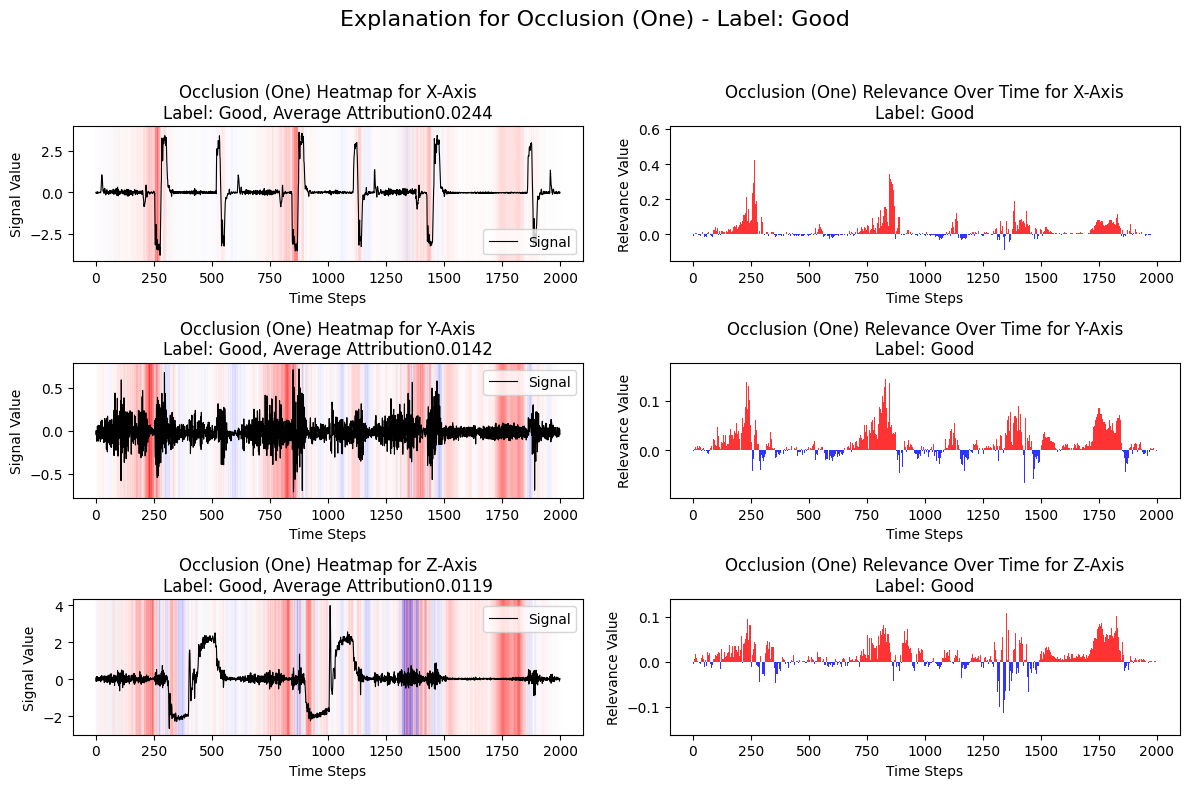

In [58]:
# Occlusion (one occlusion)
occlusion_attr_one, _ = occlusion_signal_relevance(best_model, sample, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_one, label, "Occlusion (One)")


Min relevance: -0.1302194595336914, Max relevance: 0.3051261901855469
 Maximum Absolute Attribution in Axis 0: 0.3051261901855469
 Maximum Absolute Attribution in Axis 1: 0.1302194595336914
 Maximum Absolute Attribution in Axis 2: 0.20769309997558594


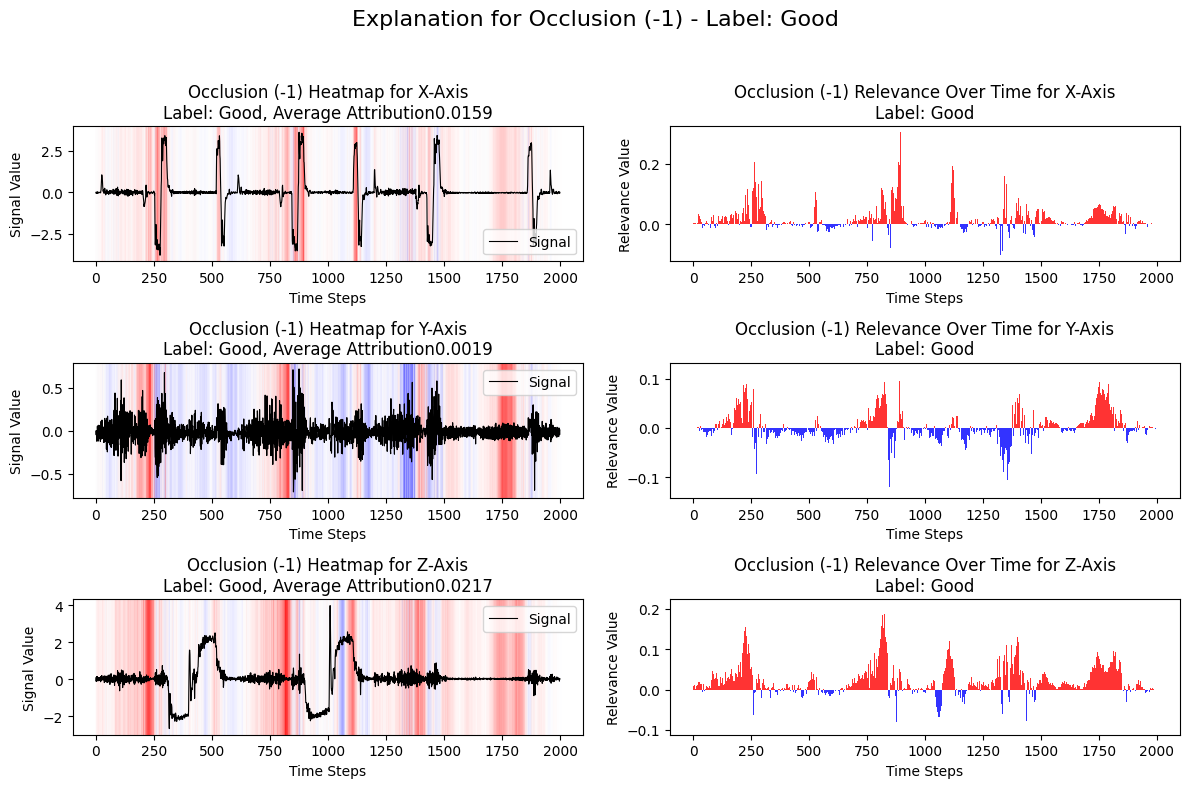

In [59]:
# Occlusion (-one occlusion)
occlusion_attr_mone, _ = occlusion_signal_relevance(best_model, sample, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_mone, label, "Occlusion (-1)")


Min relevance: -0.16086101531982422, Max relevance: 0.7719564437866211
 Maximum Absolute Attribution in Axis 0: 0.7719564437866211
 Maximum Absolute Attribution in Axis 1: 0.13010597229003906
 Maximum Absolute Attribution in Axis 2: 0.1662425994873047


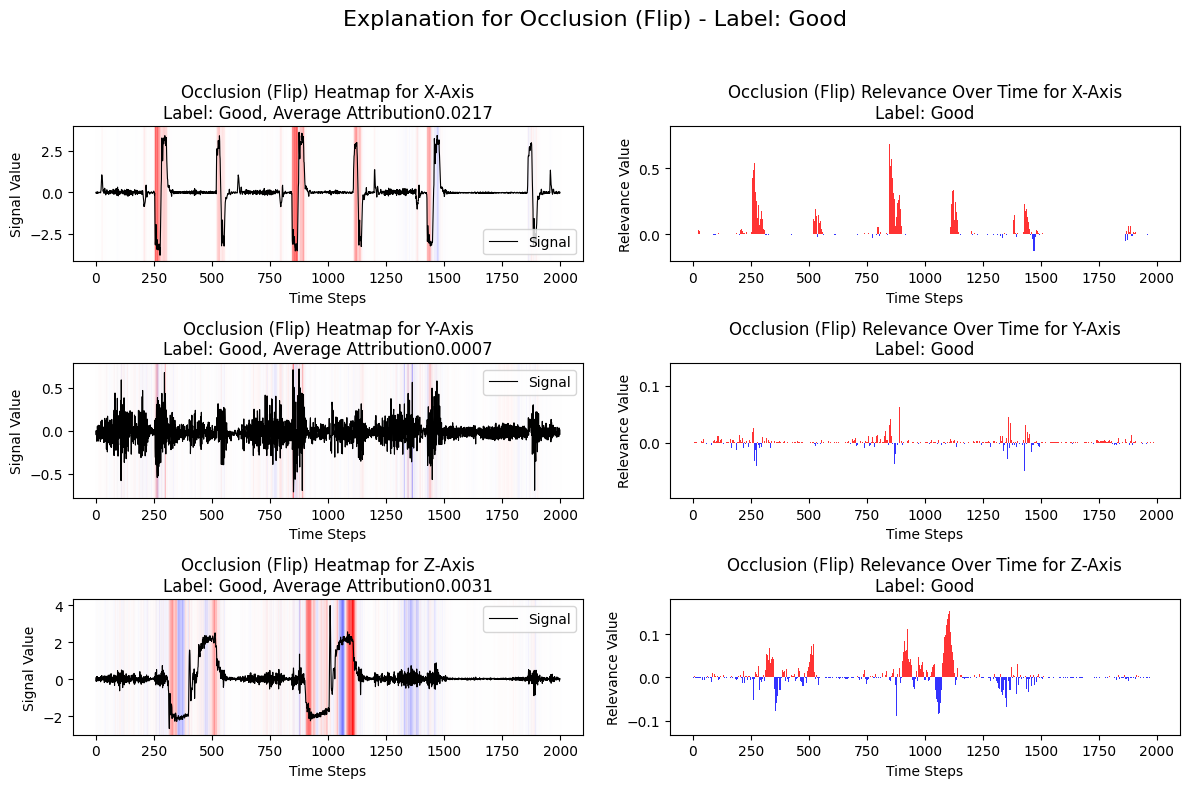

In [60]:
# Occlusion (flip occlusion)
occlusion_attr_flip, _ = occlusion_signal_relevance(best_model, sample, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip.detach().cpu().numpy())}")

visualize_with_label_attribution(sample, occlusion_attr_flip, label, "Occlusion (Flip)")


In [68]:
# Load a Bad sample

# Load a batch
sample_batch, label_batch = next(iter(train_loader))

random.seed(19)
# Choose a random index
random_index_b = random.randint(0, len(sample_batch) - 1)

# Select the random sample and its corresponding label
sample_b = sample_batch[random_index_b]  # Shape: (3, 10000)
label_b = label_batch[random_index_b]    # Shape: ()



sample_b = sample_b.to(device)
label_b = label_b.to(device)

_, predicted_label_b = predict_single(best_model, sample_b)


# Print the selected sample and label
print(f"Random Index: {random_index_b}, Predicted_label:{predicted_label_b}, True_label:{label_b}")
print(sample_b,sample_b.shape)


Random Index: 11, Predicted_label:1, True_label:1
tensor([[-0.0223,  0.1023, -0.1463,  ..., -0.1001,  0.0329, -0.0869],
        [-1.2998,  1.3248, -0.6250,  ..., -0.4046,  0.3138,  0.6535],
        [ 2.1286, -2.1617,  0.8222,  ..., -0.2444, -1.3292, -2.5613]],
       device='cuda:0') torch.Size([3, 2000])


Sample device: cuda:0
Model device: cuda:0
Target device: cuda:0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Sample 104 Label: Bad


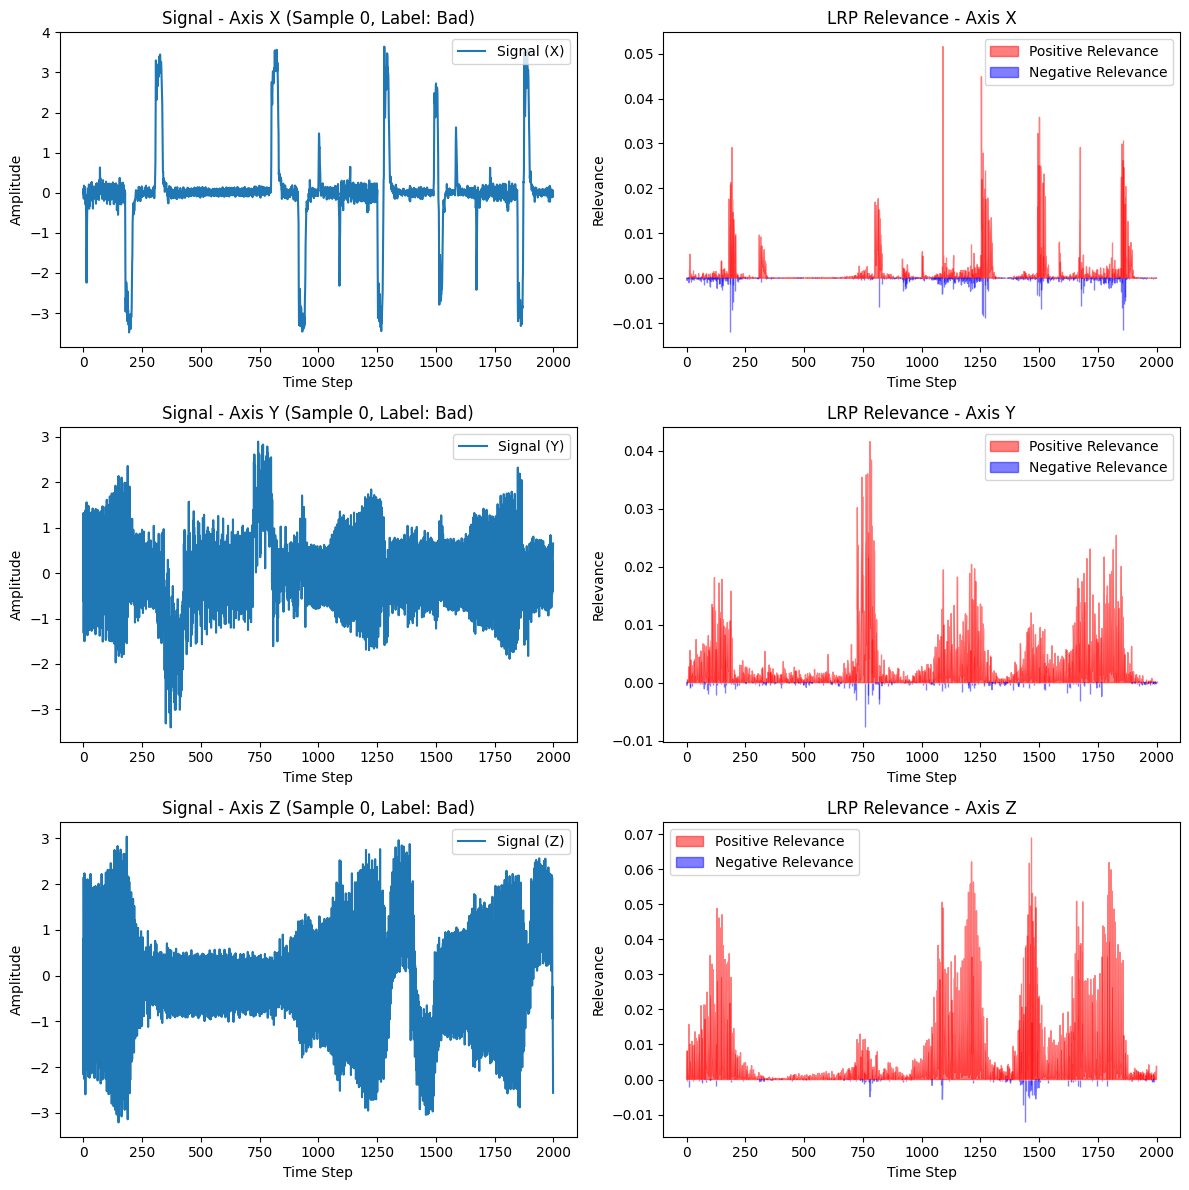

In [110]:
relevance_b, input_signal_b, final_label_b = compute_lrp_relevance(
    model=best_model,
    sample=sample_b,  # Shape: (3, 10000) or torch tensor
    label=label_b,  # Use true label or None for prediction
    device=device
)
print(f"Sample {random_index} Label: {'Good' if final_label_b == 0 else 'Bad'}")

# Visualize LRP relevances (use your existing `visualize_lrp_relevance_single_sample` function)
visualize_lrp_single_sample(
    signal=input_signal_b,
    relevance=relevance_b,
    label=final_label_b)

Min relevance: -0.012249087914824486, Max relevance: 0.06930305063724518
 Maximum Absolute Attribution in Axis 0: 0.051560308784246445
 Maximum Absolute Attribution in Axis 1: 0.04155627265572548
 Maximum Absolute Attribution in Axis 2: 0.06930305063724518


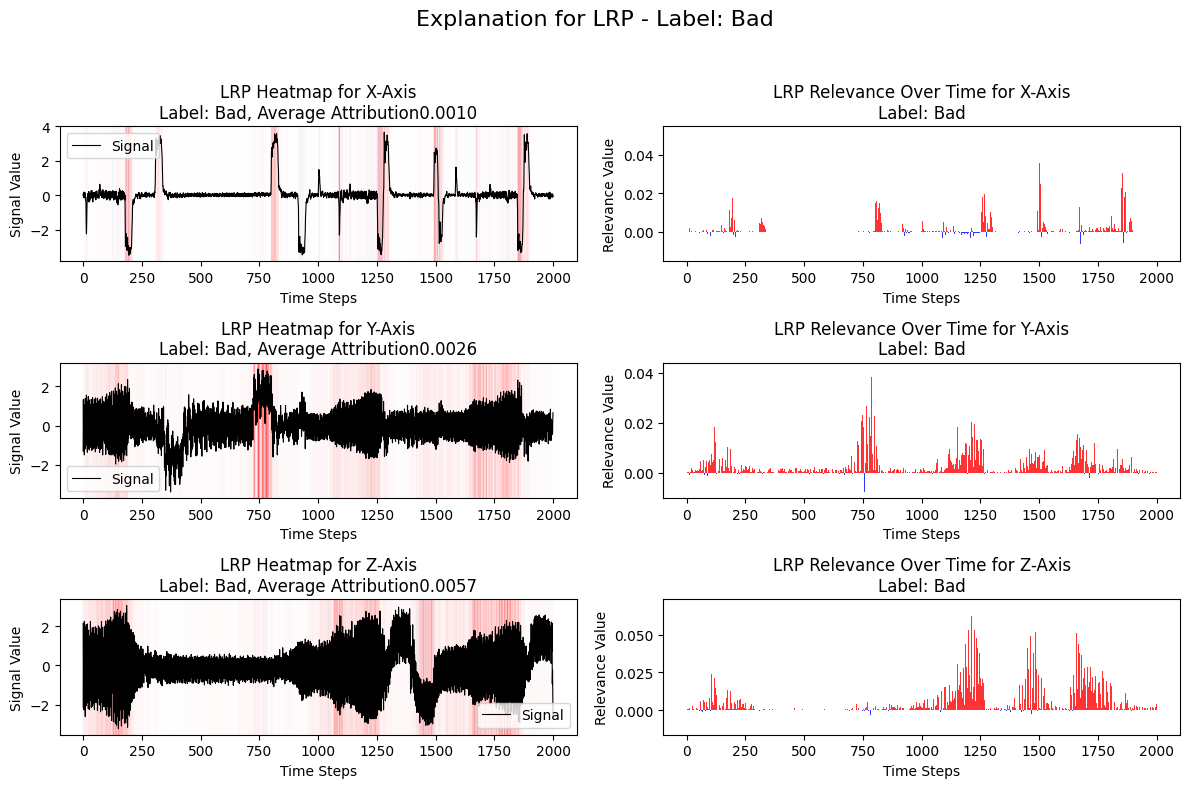

In [112]:

print(f"Min relevance: {np.min(relevance_b)}, Max relevance: {np.max(relevance_b)}")
visualize_with_label_attribution(sample_b, relevance_b, label_b, "LRP")


Min relevance: -8.187267303466797, Max relevance: 4.437215805053711
 Maximum Absolute Attribution in Axis 0: 8.187267303466797
 Maximum Absolute Attribution in Axis 1: 2.9611082077026367
 Maximum Absolute Attribution in Axis 2: 2.5901248455047607


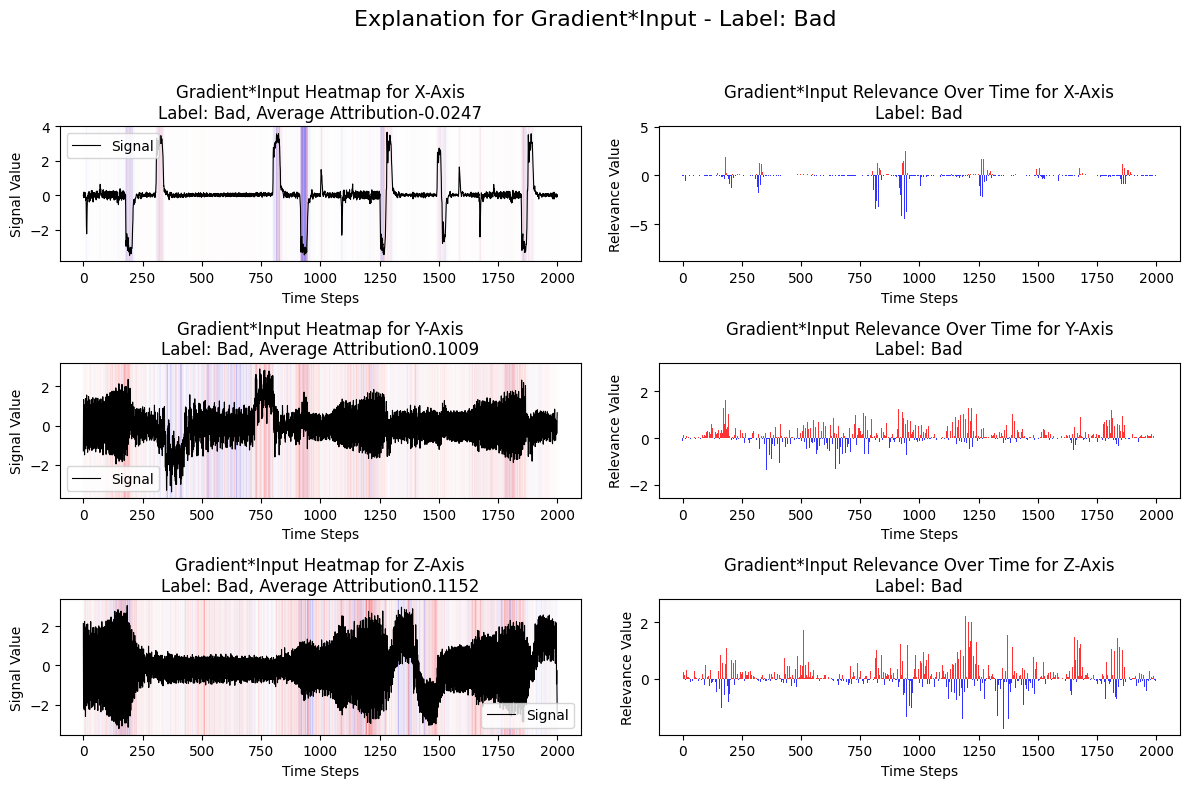

In [113]:
# Grad*Input
grad_input_attr_b, _ = grad_times_input_relevance(best_model, sample_b)
print(f"Min relevance: {np.min(grad_input_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, grad_input_attr_b, label_b, "Gradient*Input")

In [114]:
# Example usage
summary_b_g = summarize_attributions(grad_input_attr_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data_b_g = []
for axis, values in summary_b_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_g.append(row)

# Create the DataFrame
df_summary_b_g = pd.DataFrame(data_b_g)

# Display the DataFrame as a table
print(df_summary_b_g)


     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1110                181.538422   
1  Axis 1            1207                339.123779   
2  Axis 2            1172                391.841431   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.163548             890               -230.929184   
1                    0.280964             793               -137.361710   
2                    0.334336             828               -161.434265   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.259471                   -49.390762   
1                   -0.173218                   201.762070   
2                   -0.194969                   230.407166   

   Average Relevance (Pos + Neg)  
0                      -0.024695  
1                       0.100881  
2                       0.115204  


Min relevance: -3.7248215675354004, Max relevance: 3.1038901805877686
 Maximum Absolute Attribution in Axis 0: 3.7248215675354004
 Maximum Absolute Attribution in Axis 1: 2.9501984119415283
 Maximum Absolute Attribution in Axis 2: 2.6696579456329346


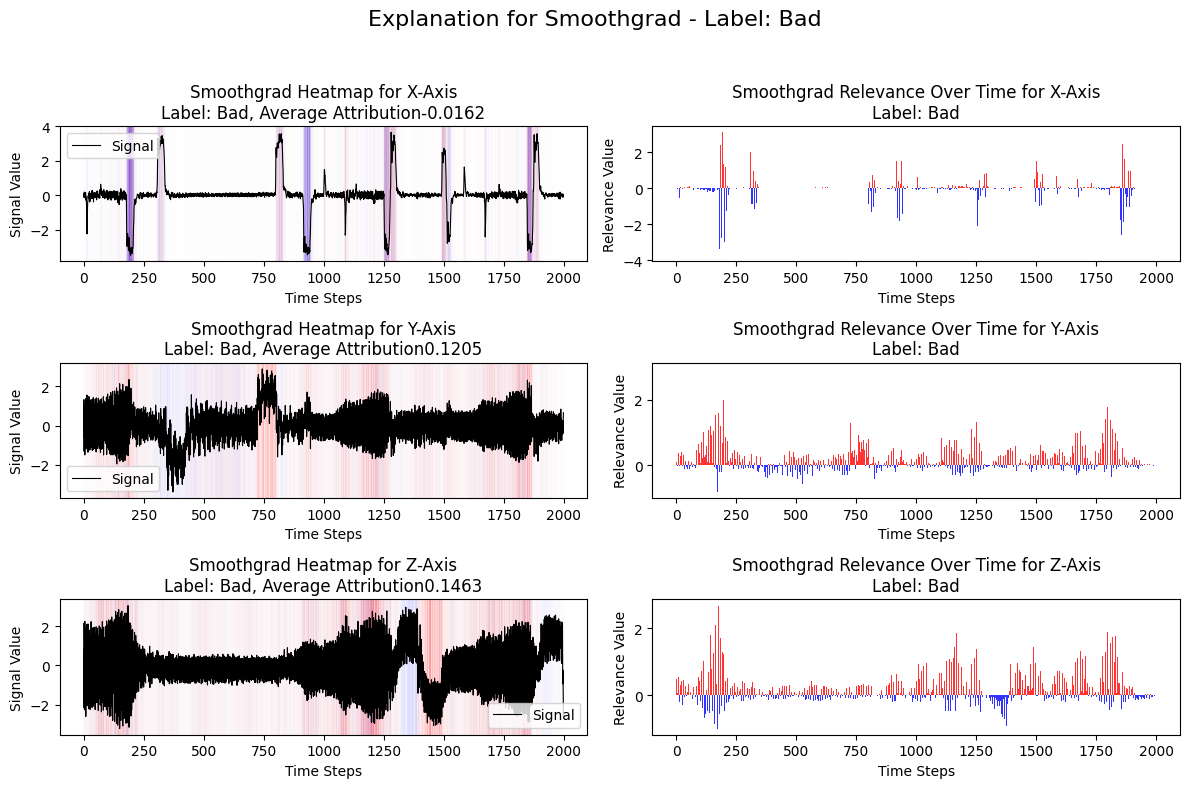

In [115]:
# SmoothGrad
smoothgrad_attr_b, _ = smoothgrad_relevance(best_model, sample_b)
print(f"Min relevance: {np.min(smoothgrad_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, smoothgrad_attr_b, label_b, "Smoothgrad")


In [116]:
# Example usage
summary_b_sg = summarize_attributions(smoothgrad_attr_b.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_b_sg = []
for axis, values in summary_b_sg.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_sg.append(row)

# Create the DataFrame
df_summary_b_sg = pd.DataFrame(data_b_sg)

# Display the DataFrame as a table
print(df_summary_b_sg)# Flatten the summary dictionary and create a DataFrame


     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1150                146.827881   
1  Axis 1            1102                350.680725   
2  Axis 2            1054                417.206665   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.127676             850               -179.129181   
1                    0.318222             898               -109.720001   
2                    0.395832             946               -124.602921   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.210740                   -32.301300   
1                   -0.122183                   240.960724   
2                   -0.131716                   292.603760   

   Average Relevance (Pos + Neg)  
0                      -0.016151  
1                       0.120480  
2                       0.146302  


Min relevance: -0.3899955749511719, Max relevance: 0.1753559112548828
 Maximum Absolute Attribution in Axis 0: 0.3899955749511719
 Maximum Absolute Attribution in Axis 1: 0.12851524353027344
 Maximum Absolute Attribution in Axis 2: 0.11111068725585938


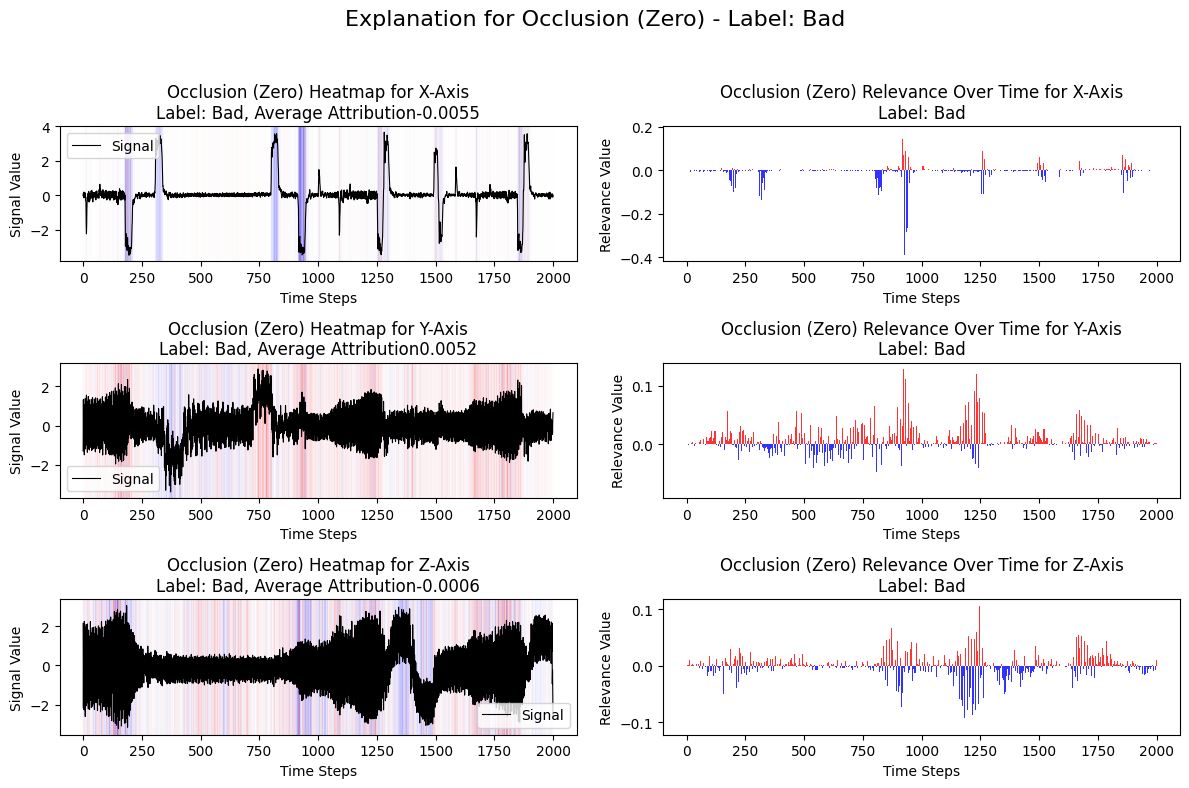

In [117]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_b, _ = occlusion_signal_relevance(best_model, sample_b, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_zero_b, label_b, "Occlusion (Zero)")

Min relevance: -0.5129203796386719, Max relevance: 0.18122100830078125
 Maximum Absolute Attribution in Axis 0: 0.5129203796386719
 Maximum Absolute Attribution in Axis 1: 0.13619613647460938
 Maximum Absolute Attribution in Axis 2: 0.149658203125


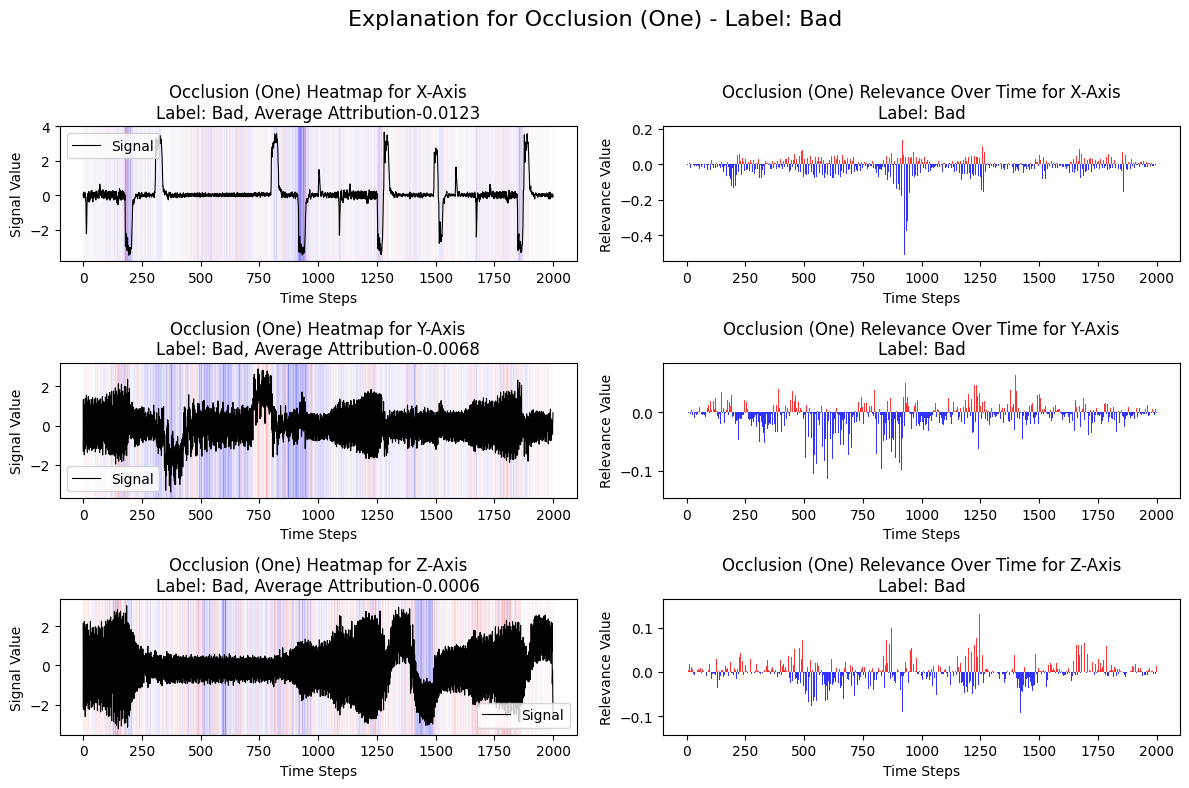

In [118]:
# Occlusion (one occlusion)
occlusion_attr_one_b, _ = occlusion_signal_relevance(best_model, sample_b, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_one_b, label_b, "Occlusion (One)")

Min relevance: -0.2898273468017578, Max relevance: 0.19646263122558594
 Maximum Absolute Attribution in Axis 0: 0.2898273468017578
 Maximum Absolute Attribution in Axis 1: 0.19646263122558594
 Maximum Absolute Attribution in Axis 2: 0.20371246337890625


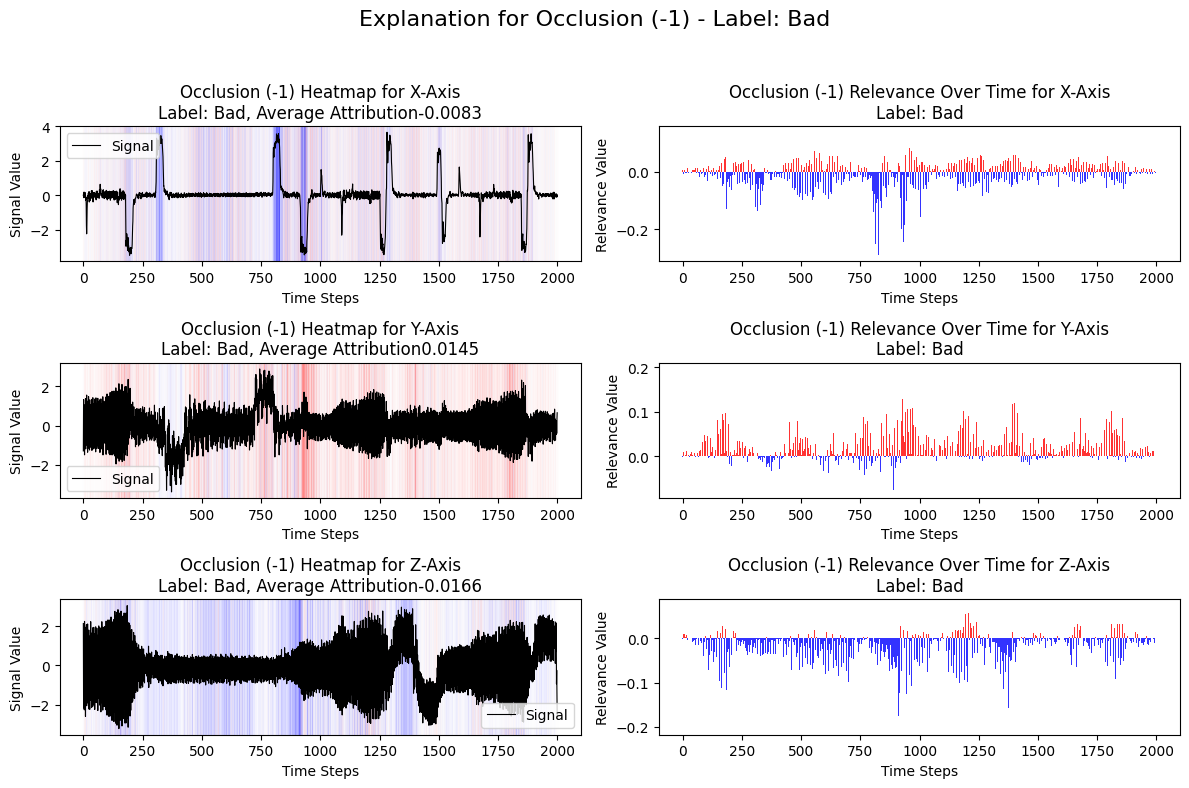

In [77]:
# Occlusion (-one occlusion)
occlusion_attr_mone_b, _ = occlusion_signal_relevance(best_model, sample_b, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_mone_b, label_b, "Occlusion (-1)")

Min relevance: -0.6432743072509766, Max relevance: 0.24092674255371094
 Maximum Absolute Attribution in Axis 0: 0.6432743072509766
 Maximum Absolute Attribution in Axis 1: 0.24092674255371094
 Maximum Absolute Attribution in Axis 2: 0.2220916748046875


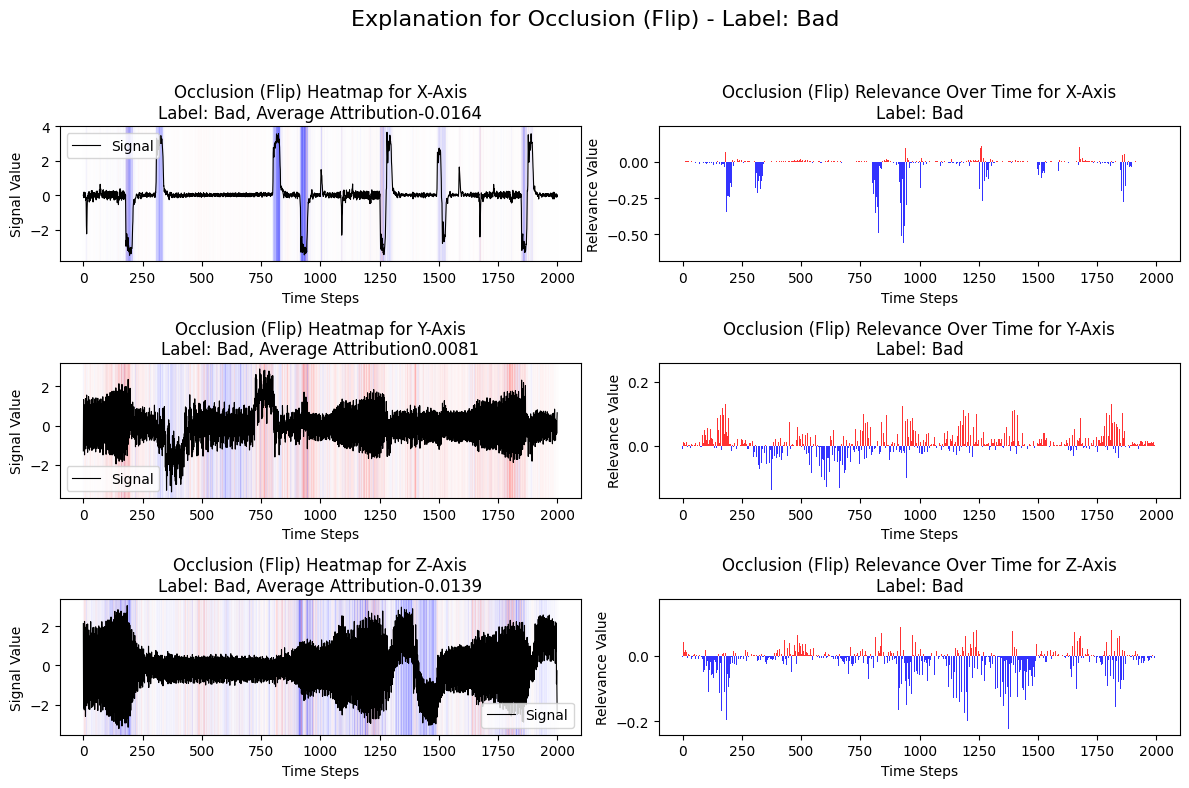

In [78]:

# Occlusion (e.g., zero-based occlusion)
occlusion_attr_flip_b, _ = occlusion_signal_relevance(best_model, sample_b, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip_b.detach().cpu().numpy())}")

visualize_with_label_attribution(sample_b, occlusion_attr_flip_b, label_b, "Occlusion (Flip)")


In [119]:
relevance_time_b, relevance_freq_b, signal_freq_b, input_signal_b, freqs_b, predicted_label_b = compute_dft_lrp_relevance(
        model=best_model,
        sample=sample_b.cpu().detach().numpy(),  # Convert to NumPy for DFTLRP
        label=label_b.item(),
        device=device,
        signal_length=2000,
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Input sample shape: torch.Size([1, 3, 2000])
Relevance time shape: (3, 2000)
Input signal shape: (3, 2000)
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Number of axis is: 3
Frequency length is:1001
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relevance hat shape after multiplication: torch.Size([1, 2000])
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relev

E:\Thesis\Datasets\CNC\utils\dft_lrp.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=dtype)


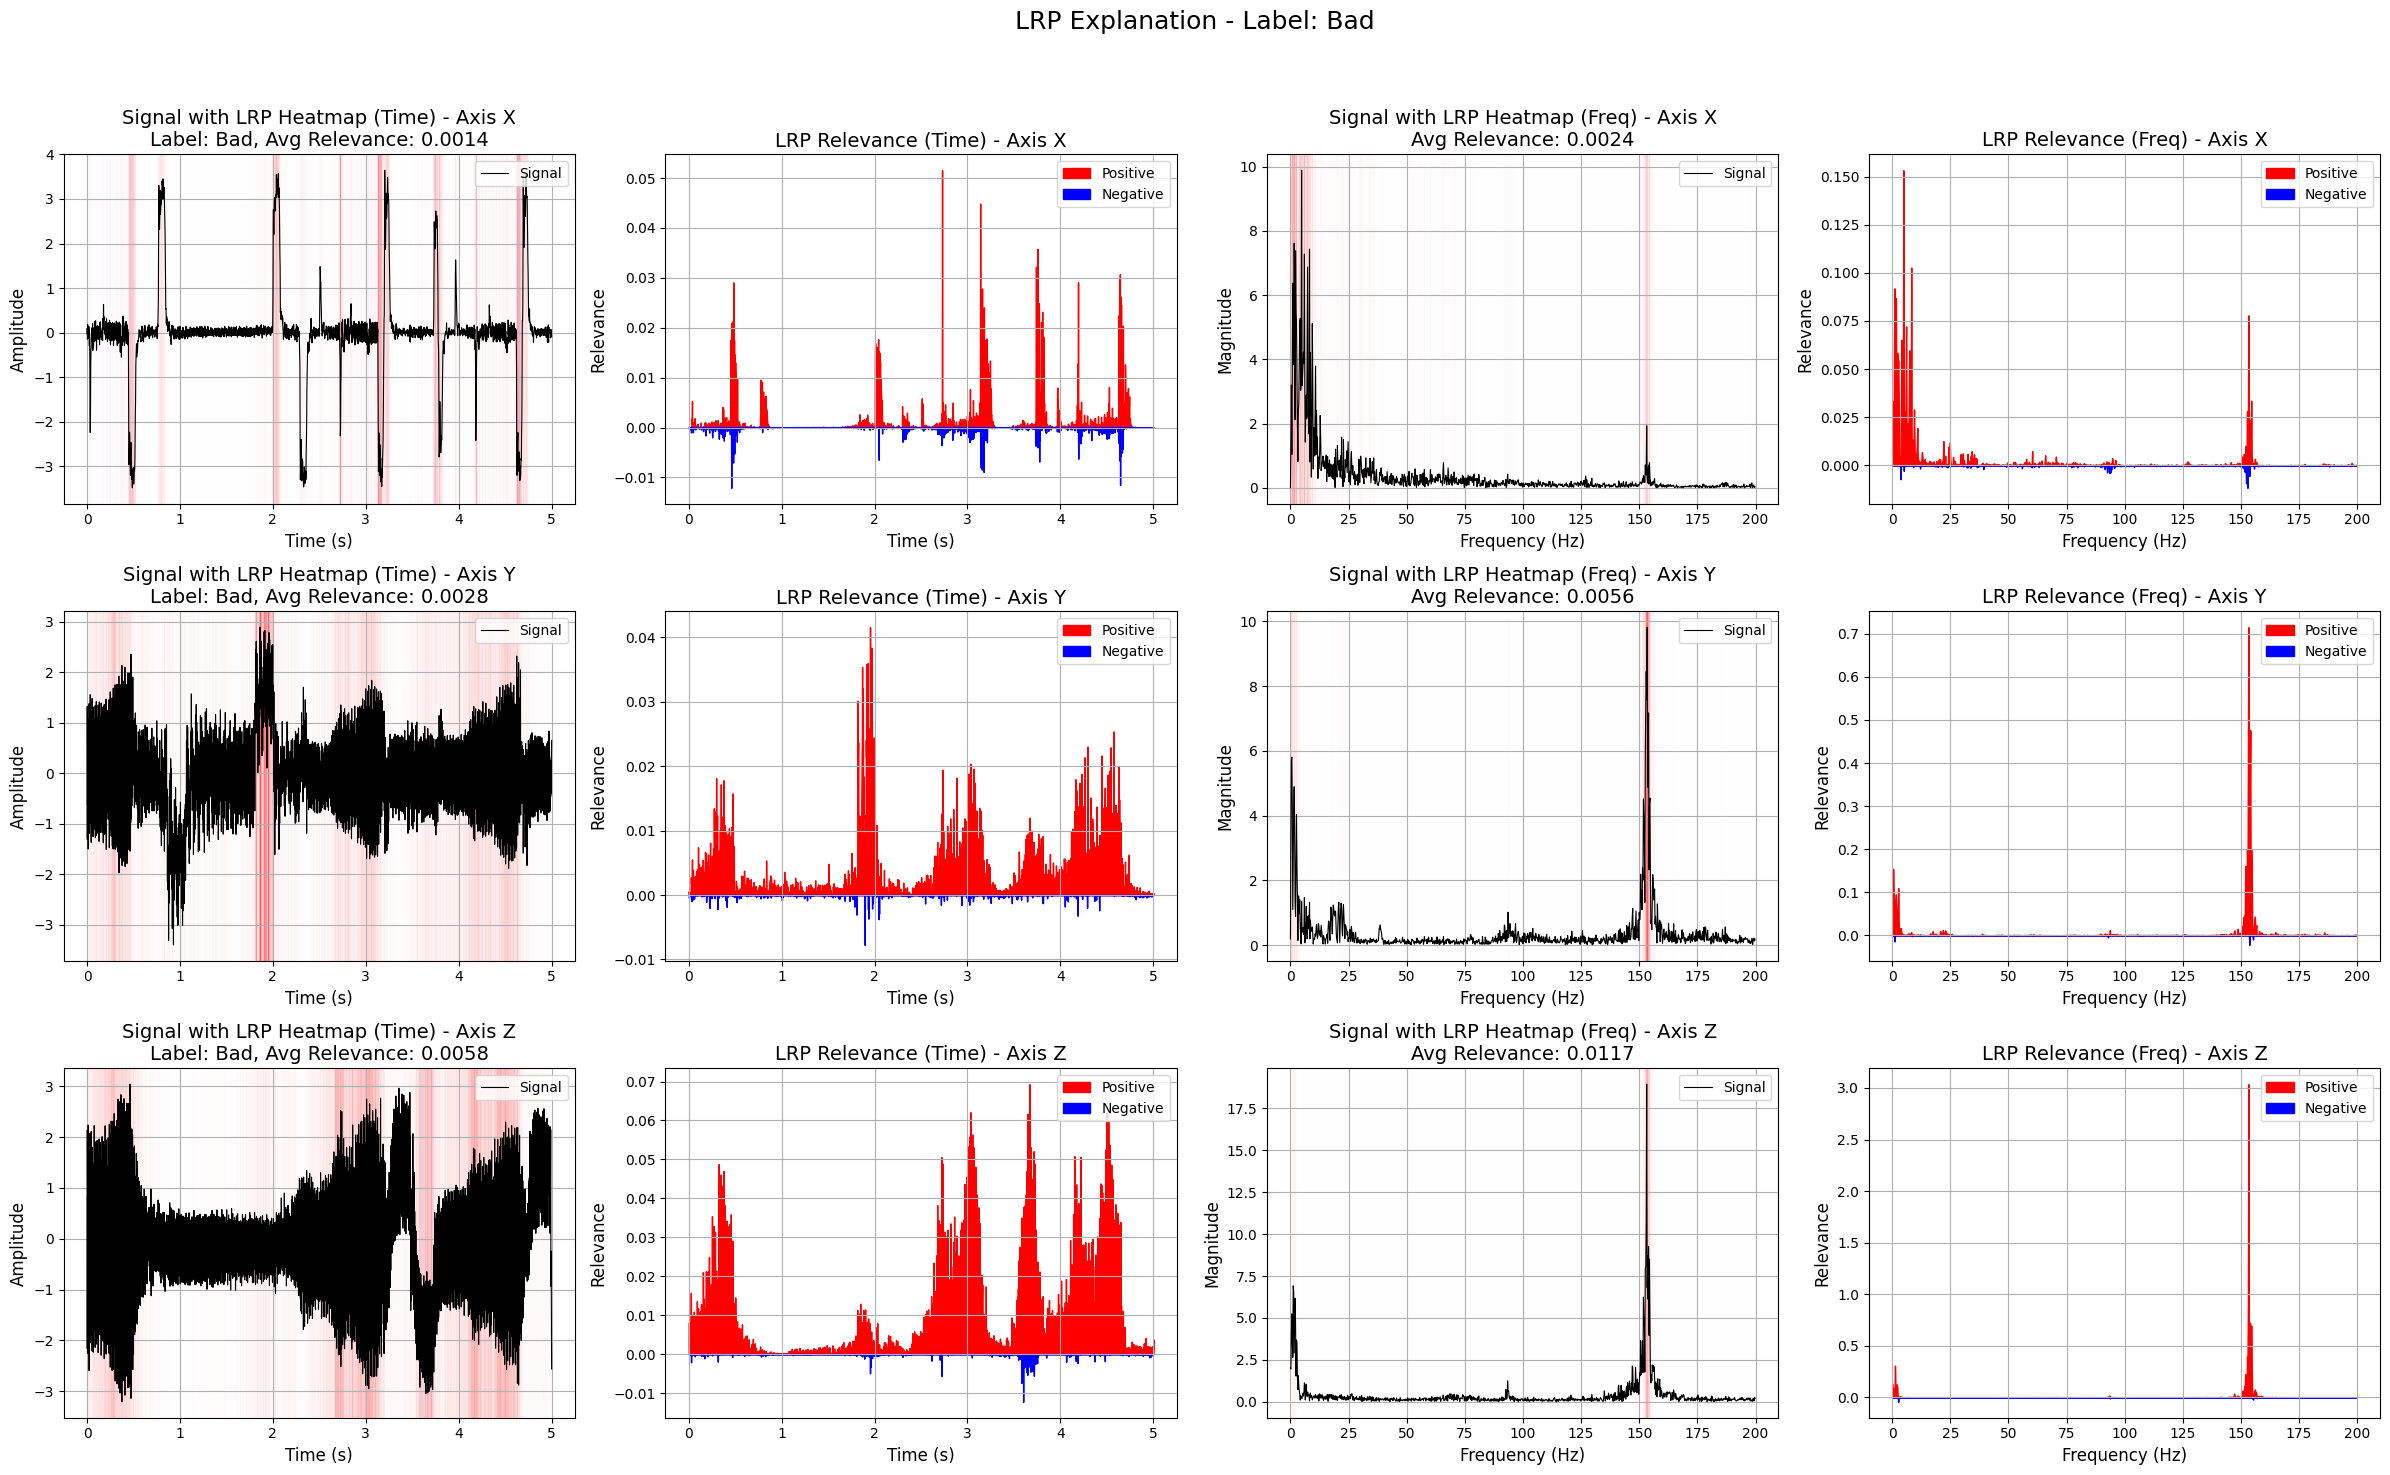

In [120]:
# Visualize the results
visualize_lrp_dft(
        relevance_time=relevance_time_b,
        relevance_freq=relevance_freq_b,
        signal_freq=signal_freq_b,
        input_signal=input_signal_b,
        freqs=freqs_b,
        predicted_label=predicted_label_b,
        k_max=1000,  # Plot up to 1000 Hz
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

In [121]:
summary_b_of = summarize_attributions(occlusion_attr_flip_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data = []
for axis, values in summary_b_of.items():
    row = {"Axis": axis}
    row.update(values)
    data.append(row)

# Create the DataFrame
df_summary = pd.DataFrame(data)

# Display the DataFrame as a table
print(df_summary)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1022                  8.482386   
1  Axis 1            1195                 31.029951   
2  Axis 2             741                 12.217850   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.008300             977                -41.298164   
1                    0.025966             804                -14.869987   
2                    0.016488            1259                -39.953056   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.042270                   -32.815781   
1                   -0.018495                    16.159964   
2                   -0.031734                   -27.735207   

   Average Relevance (Pos + Neg)  
0                      -0.016416  
1                       0.008084  
2                      -0.013868  


In [123]:
summary_b_lrp = summarize_attributions( relevance_freq_b)  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data_lrp = []
for axis, values in summary_b_lrp.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp.append(row)

# Create the DataFrame
df_summary_lrp = pd.DataFrame(data_lrp)

# Display the DataFrame as a table
print(df_summary_lrp)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             646                  2.205667   
1  Axis 1             722                  5.433049   
2  Axis 2             711                 11.517588   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.003414             355                 -0.148850   
1                    0.007525             279                 -0.141599   
2                    0.016199             290                 -0.209771   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.000419                     2.056817   
1                   -0.000508                     5.291450   
2                   -0.000723                    11.307817   

   Average Relevance (Pos + Neg)  
0                       0.002055  
1                       0.005286  
2                       0.011297  


In [124]:
""# Global Attribution over frequency with LRP
summary_lrp_t_b = summarize_attributions(relevance_time_b)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_lrp_t_b = []
for axis, values in summary_lrp_t_b.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp_t_b.append(row)

# Create the DataFrame
df_summary_lrp_t_b = pd.DataFrame(data_lrp_t_b)

# Display the DataFrame as a table
print(df_summary_lrp_t_b)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1349                  2.386014   
1  Axis 1            1660                  5.414793   
2  Axis 2            1752                 11.452097   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.001769             651                 -0.329408   
1                    0.003262             340                 -0.123424   
2                    0.006537             248                 -0.145793   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.000506                     2.056605   
1                   -0.000363                     5.291368   
2                   -0.000588                    11.306304   

   Average Relevance (Pos + Neg)  
0                       0.001028  
1                       0.002646  
2                       0.005653  


In [127]:
relevance_time_fft_b, relevance_freq_fft_b, signal_freq_fft_b, relevance_timefreq_fft_b, signal_timefreq_fft_b, input_signal_fft_b, freqs_fft_b, predicted_label_fft_b = compute_fft_lrp_relevance(
        model=best_model,
        sample=sample_b,
        label=label_b,
        signal_length=2000,
        sampling_rate=400,
        compute_timefreq=True,
        window_shift=64,  # Increased to reduce memory usage
        window_width=128,
        window_shape="rectangle"
    )

Input sample shape: torch.Size([1, 3, 2000])
Target label: tensor([1], device='cuda:0')
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
relevance_time_tensor shape before squeeze: (1, 3, 2000)
relevance_time shape after squeeze: (3, 2000)
input_signal shape: (3, 2000)
fft_lrp: Input relevance shape = (1, 2000), signal shape = (1, 2000)
fft_lrp: relevance_tensor shape = torch.Size([1, 2000]), signal_tensor shape = torch.Size([1, 2000])
fourier_transform: signal_tensor shape = torch.Size([1, 2000])
fourier_transform (FFT): signal_hat shape = torch.Size([1, 1001])
fft_lrp: signal_hat shape = torch.Size([1, 1001])
fft_lrp: relevance_normed shape = torch.Size([1, 2000])
fft_lrp: relevance_fft real part = tensor([[-0.0066, -0.0079, -0.0036,  ...,  0.0054,  0.0022, -0.0020]],
       device='cuda:0')
fft_lrp: relevance_fft imag part = tensor([[ 0.0000, -0.0073,  0.0053,  ..., -0.0018,  0.0006, -0.0000]],
       device='cuda:0')
fft_lrp: relevance_hat real 

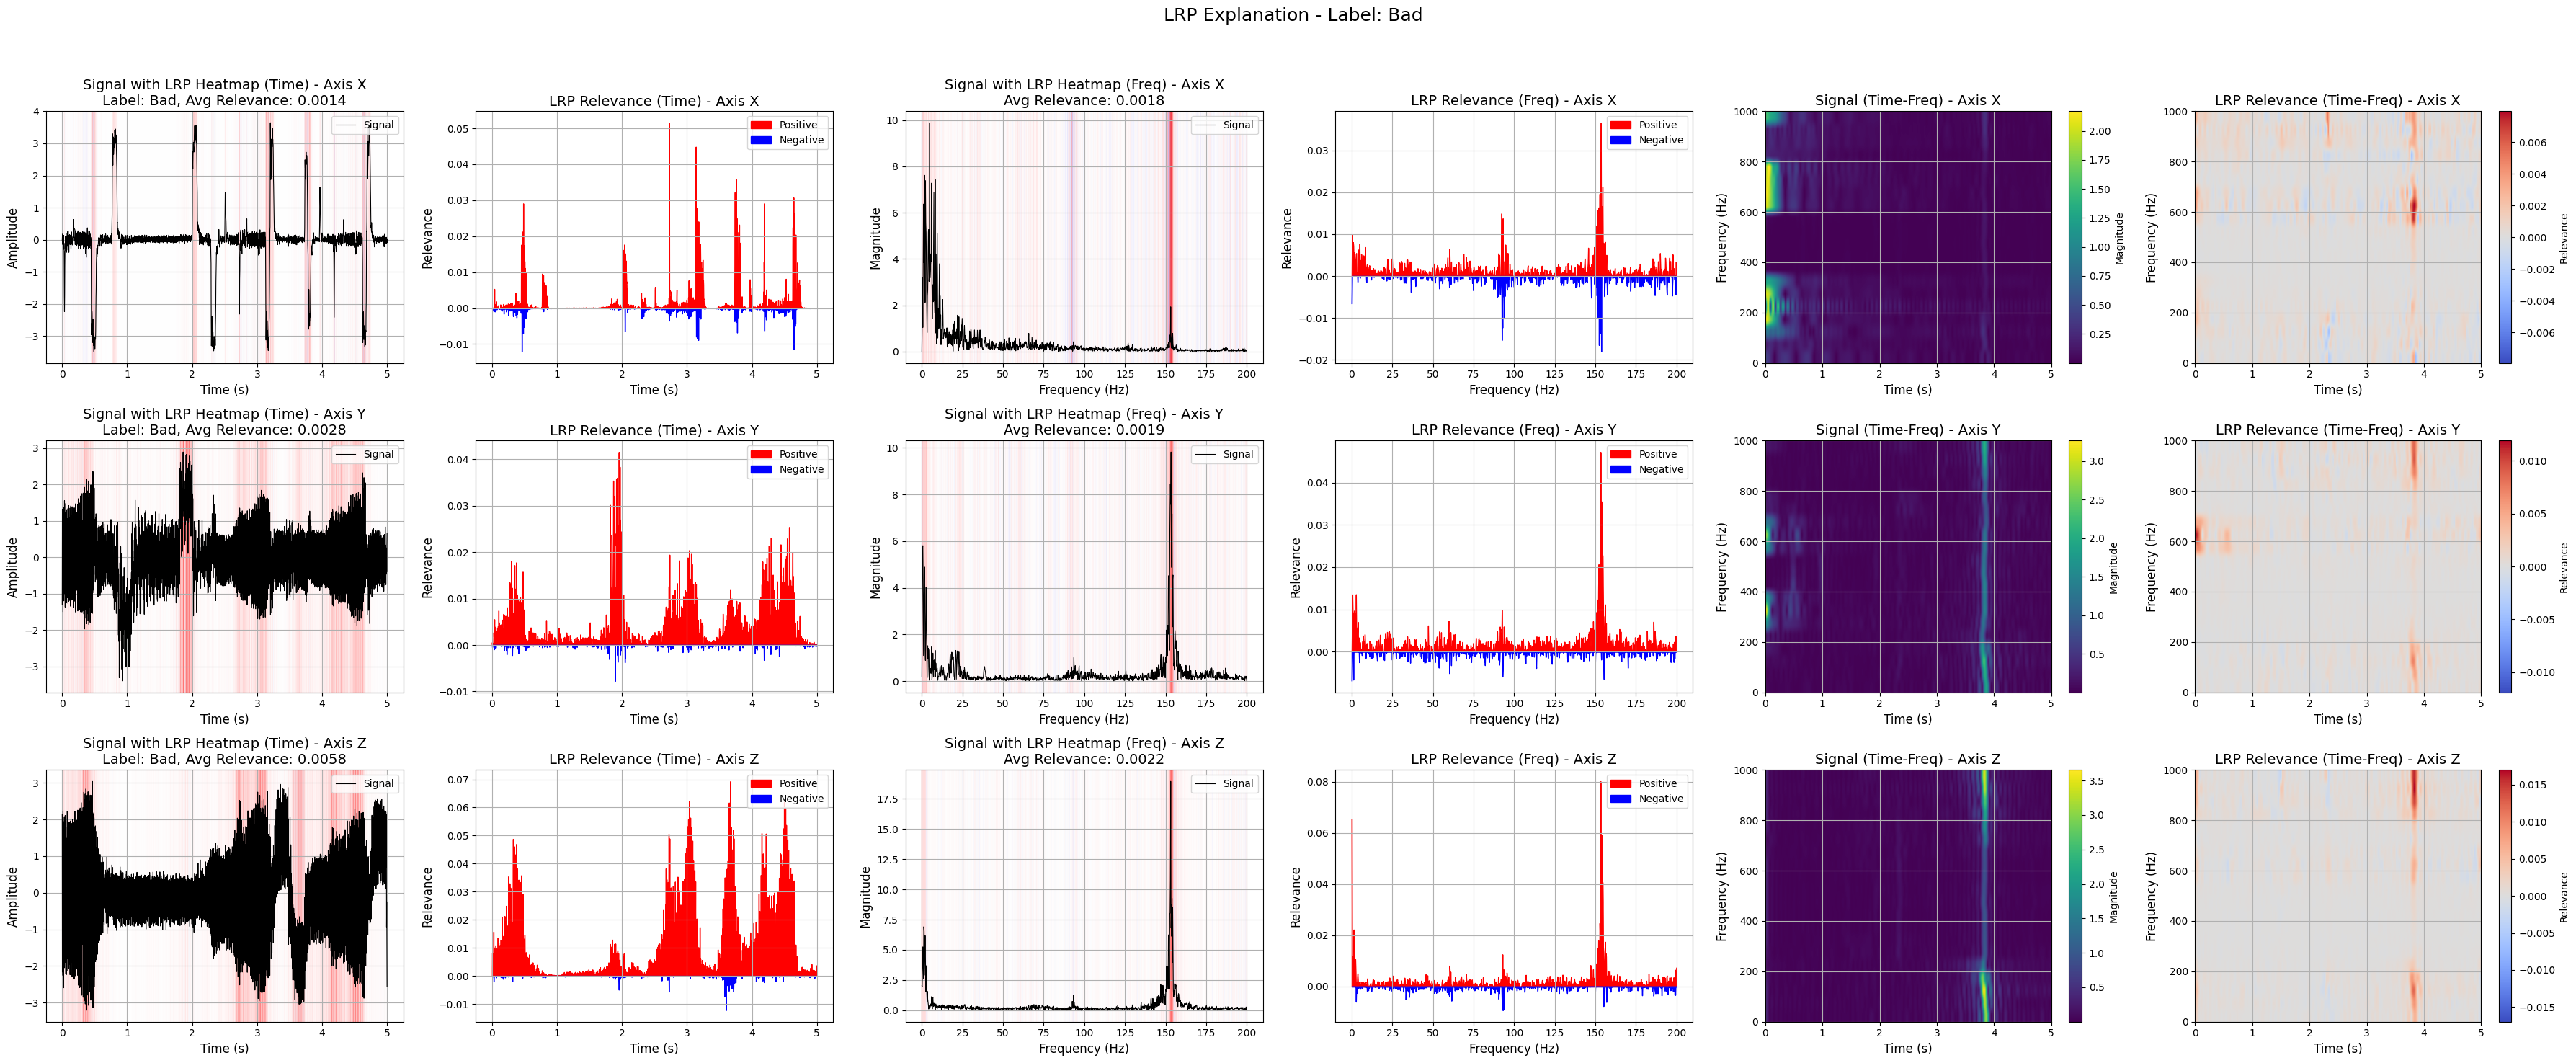

In [128]:
# Visualize
visualize_lrp_fft(
    relevance_time=relevance_time_fft_b,
    relevance_freq=relevance_freq_fft_b,
    signal_freq=signal_freq_fft_b,
    relevance_timefreq=relevance_timefreq_fft_b,
    signal_timefreq=signal_timefreq_fft_b,
    input_signal=input_signal_fft_b,
    freqs=freqs_fft_b,
    predicted_label=predicted_label_fft_b,
    signal_length=2000,
    sampling_rate=400,
    k_max=1000
)